<figure>
    <img src="./pics/header.png" width="1000" alt="Header"/>
</figure>

## Table of Contents:
I - [Introduction / Significance statement](#1)

II - [Methods](#2)
- [Input fields](#2.1)
- [Models](#2.2)
- [Data formatting](#2.3)
- [Settings](#2.4)
- [Regions of interest](#2.5)
- [Training data](#2.6)

III - [First Implementation : New Zealand](#3) 
- [Loading data](#3.1)
- [Model training hyperparameters](#3.2)
- [Compilation](#3.3)
- [Model Training](#3.4)
- [Load models with weights](#3.5)
- [Inference](#2.6)
- [Performance analysis](#2.7)

IV - [Second Implementation : France (without topography added in input)](#4) 
- [Loading data](#4.1)
- [Model training hyperparameters](#4.2)
- [Compilation](#4.3)
- [Model Training](#4.4)
- [Load models with weights](#4.5)
- [Inference](#4.6)
- [Performance analysis](#4.7)

V - [Second Implementation : France (without topography added in input)](#5) 
- [Loading data](#5.1)
- [Model training hyperparameters](#5.2)
- [Compilation](#5.3)
- [Model Training](#5.4)
- [Load models with weights](#5.5)
- [Inference](#5.6)
- [Performance analysis](#5.7)

VI - [Effect of topography as additional input (France)](#6) 
- [Prediction difference](#6.1)
- [Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the space dimension)](#6.2)
- [Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the time dimension)](#6.3)

VII - [Discussion & Conclusion](#7)

VIII - [References](#8)

##  I - Introduction / Significance statement <a class="anchor" id="1"></a>

A major and longstanding challenge for climate science is to provide reliable climate projections at high spatial resolution. 

<figure style="text-align: center;">
    <img src="pics/resolution.png" width="700" alt="Improvement in resolution with time (IPCC)" />
</figure>

Precipitation forecast at a high resolution is needed for many sectors such as agriculture, flood prevention or even tourism. Though, the resolution of general circulation models (GCMs) is very low compared to what decision-makers necessitate.

<figure style="text-align: center;">
    <img src="pics/snow_rain.png" width="700" alt="Pictures of snow and floods" />
</figure>

Temperature, humidity and wind fields output of GCMs are often considered more reliable because they represent fundamental aspects of the atmospheric circulation are influenced by well-understood physical principles. Precipitation, on the other hand, involves complex processes at multiple scales and GCMs still struggle to accurately simulate local variations of precipitation. Precipitation is influenced by factors like cloud microphysics, convective processes, and topographical features making it more challenging to model accurately. Also, precipitation is distributed along a gamma distribution, which has binary component: it’s either rainy or not. While GCMs have improved in representing precipitation patterns, there are still uncertainties, especially at regional and local levels.

Different methods of downscaling can be used to improve the resolution of GCMs  in a reliable way, such as statistical downscaling and dynamical downscaling using regional climate models, but both methods are costly and subject to GCMs-induced biases.

On the other hand, downscaling from a lower resolution set of GCM fields of wind, temperature and specific humidity using a deep learning approach could be an energy-efficient method, independent from model biases, once models are trained.


**In this computing project, I aim to predict high resolution precipitation from lower resolution atmospheric fields with neural networks.
Because, despite their *opacity* they are very efficient once the model is trained, contrary to other statistical but especially dynamical downscaling methods.** 

<figure style="text-align: center;">
    <img src="pics/goal.png" width="700" alt="Description of image">
</figure>

## II - Methods <a class="anchor" id="2"></a>

In this project, I use 4 models defined by Rampal *et al.* (2022) that predict for a given day the total precipitation for each point of a high resolution grid (0.1 $\times$ 0.1 °) using lower resolution (0.5 $\times$ 0.5 °) 2D atmospheric fields of the same day (daily mean). 

### 1) Input fields <a class="anchor" id="2.1"></a>

The atmospheric fields used here, are :

- u$_{850}$ : zonal wind at 850 hPa (m.s$^{-1}$)
- v$_{850}$ : meridional wind at 850 hPa (m.s$^{-1}$)
- w$_{850}$ : vertical wind at 850 hPa (m.s$^{-1}$)
- q$_{850}$ : specific humidity at 850 hPa (kg.kg$^{-1}$)
- t$_{850}$ : temperature at 850 hPa (K)
- z (optionally) : elevation (m)


<figure style="text-align: center;">
    <img src="pics/vars.png" width="60%" alt="Description of image">
</figure>

Topography / elevation was added to the input variables for France, at a low resolution (similiar to the other inputs, for processing issues, or else my computer would crash). Therefore, I do not expect a great improvement of the model, because topography is only useful at a pretty high resolution. I just wanted to check if my model would improve at all with this additional input. **But a machine learning model should not need topography, since it is constant with time and therefore it should already appear in its impact on the atmospheric fields**. 

### 2) Models <a class="anchor" id="2.2"></a>

This whole project was made using Tenserflow Keras (Chollet *et al*, 2015).

#### Base

Each of the 4 models belongs to either type of neural network : 

- **DNN** : The **D**ense **N**eural **N**etwork connects every neuron in one layer to every neuron in the next layer. It is most effective for structured data and tasks like classification. 

    <figure style="text-align: center;">
        <img src="pics/DNN.png" width="60%" alt="Description of image">
    </figure>

    The DNN extract features in a flattened way, which means that it doesn't see spatial correlation : every pixel is independant from the other. The `dropout` at the end keeps the model from over fitting and the last dense layer starts doing the regression.
    
- **CNN** : The **C**onvolutional **N**eural **N**etwork is used for processing gridded data. It uses convolutional layers to automatically and adaptively learn spatial hierarchies of features. It is the most effective type of model for image recognition and computer vision.

    <figure style="text-align: center;">
        <img src="pics/CNN.png" width="100%" alt="Description of image">
    </figure>

    This CNN base is made of a repetitive pattern of `conv average pooling` to reduce data and `batch normalization` to avoid drifting by normalizing weights, leading to a flattened dense layer with `dropout`, to also keep from over fitting. See the **Settings** section below, for further explaination. The convolutional layers extract the spatials features from the images while the dense layer at the end, start to find connexions with the prediction, and try to do a regression.

#### Scheme

To "learn", a model needs to get its prediction $y_{pred}$ closest to the ground truth $y_{truth}$ . To do so, it uses a loss function which needs to be minimized (by differents methods, such as gradient descent). There are many loss functions, for differents tasks such as classification or regression.
Here, we use **two schemes** that we can add to our base models. One only does regression *(i.e. predicts the precipitation scalar for each gridpoint)*, the **simple** one while the other one also takes into accound the binary component of rainfall, the **complex** one. 

Here they are in detail : 

- "**Simple**" scheme : It uses a **MSE loss function** which returns one scalar value of precipitation for a given day for each point at a high resolution (0.1 $\times$ 0.1 °) from the lower resolution (0.5 $\times$ 0.5 °) 2D atmospheric fields provided in input (here, for NZ, it's the zonal, meridional and vertical  wind, the temperature and the specific humidity at 850 hPa). 

$$ \text{MSE} = \frac{1}{N}(y_{true}-y_{pred})^2 $$


<figure style="text-align: center;">
    <img src="pics/simple.png" width="30%" alt="Description of image">
</figure>



- "**Complex**" scheme : It uses a $\Gamma$ loss function, the log-likelihood of the Bernoulli-$\Gamma$ distribution : 


    \begin{equation*} 
    \text{L}(p, \alpha, \beta; y_{true}, y_{pred})=(1- p_{true})\log(1-p+\epsilon)\\+ p_{true} \left[ \log(p+\epsilon)  + (\alpha -1)\log(y_{true} + \epsilon) + \alpha  \log(\beta+\epsilon) - \log(\Gamma(\alpha))\right] \\ - \frac{y_{true}}{(\beta + \epsilon)} 
    \end{equation*}

    where :
    - $y_{true}$ is the true rainfall amount
    - $p_{true}$ is binary rainfall (1 : rain, 0 : no rain)
    - $p$ is the probability of rainfall predicted by the neural network
    - $\alpha$ is the shape parameter of the $\Gamma$ distribution
    - $\beta$ is the scale parameter of the $\Gamma$ distribution
    - $\epsilon$ is the regularization parameter
    - $y_{pred}(p, \alpha, \beta)$ represents the predicted rainfall amount.
    
    
    <figure style="text-align: center;">
        <img src="pics/complex.png" width="40%" alt="Description of image">
    </figure>

    This **$\Gamma$ loss function** returns 3 scalar values ($\alpha$, $\beta$, $p$) for a given day for each point at a high resolution (0.1 $\times$ 0.1 °) from the lower resolution (0.5 $\times$ 0.5 °) 2D atmospheric fields provided in input (here, for NZ, it's the zonal, meridional and vertical  wind, the temperature and the specific humidity at 850 hPa). $\alpha$ and $\beta$ are the shape and scale parameters of the Bernoulli-$\Gamma$  distribution, $p$ is the probability of rainfall predicted. Then, the function `predict` computes a precipitation scalar value from these 3 parameters using the following function : 

 \begin{equation*}  \text{rainfall} = (p > 0.95) * e^{\beta}* e^{\alpha} \end{equation*}



In the end, we have 4 models : 

| Model Name    | Type | Loss       |
|---------------|------|------------|
|  Simple DNN   |  DNN |  MSE       |
|  Complex DNN  |  DNN |  $\Gamma$  |
|  Simple CNN   |  CNN |  MSE       |
|  Complex CNN  |  CNN |  $\Gamma$  |

### 3) Data formatting <a class="anchor" id="2.3"></a>
Before training, in the "Loading data" part, I put it in an appropriate format by stacking the variables into a single `feature` coordinate & I normalize the data : rescaling of the data from the original range so that all values are within the range of 0 and 1. 

I neglect the need to shuffle the data, by considering that the non-stationnarity due to global warming and natural interannual variability is "smoothed" with the normalization. In the original paper, no shuffling was done either.

### 4) Settings <a class="anchor" id="2.4"></a>
(same as in Rampal *et al.* (2022))
- Training Split : 
     - For New Zealand : 63% training, 13% validation, 22% testing.
     - For France : 50% training, 20% validation, 30% testing.
- Hyper parameters :
    - Learning rate = 1e-4 
    
        >The learning rate controls how much the weights in the network are adjusted with respect to the loss gradient. Essentially, it determines the size of the steps the network takes during training as it attempts to minimize the loss function. A learning rate of 1e-4 is considered small. Small learning rates make the training process more gradual and precise. This can be beneficial as it allows the model to steadily improve and potentially reach a better and more stable minimum in the loss landscape. A smaller learning rate reduces the risk of overshooting the minimum of the loss function. It can lead to more precise convergence and is often used to fine-tune a nearly optimized model. However, the downside is that it can make the training process significantly slower, as each update to the weights is minimal. There's also a risk of the model getting stuck in local minima or taking too long to escape flat regions in the loss landscape.
        
    - Dropout = 0.6
    
        >60% of the neurons in the previous layer will be randomly "dropped out" or deactivated during each training iteration. Dropout is a regularization technique used to prevent overfitting in neural networks.



    - Number of neurons per dense layer : 256

        >This is quite standard. The more neurons, the more time it takes to train and can easily overfit, but if you don't have enough neurons the model won't understand complex relationships.
        
        
    - Batch size = 64 
    
        >Batch size refers to the number of training examples used in one iteration of model training. In this case, a batch size of 64 means that 64 samples from the training dataset are used to compute the gradient and update the model parameters during each iteration of the training process. The choice of batch size affects the training dynamics : A smaller batch size generally provides a more accurate estimate of the gradient, but can be slower and more prone to getting stuck in local minima. A larger batch size tends to be faster in terms of computational efficiency due to better hardware utilization (like GPU parallelization), but may offer a less accurate gradient estimate.
    
    - Kernel size = (3,3)
    
        >The kernel size in a CNN refers to the dimensions of the filters used in convolutional layers. A kernel size of (3,3) means that each filter applied to the input data (such as an image) is 3 pixels by 3 pixels. The kernel size affects how the network perceives the input data. A smaller kernel size, like (3,3), is effective at capturing fine-grained details in the image, as it looks at smaller regions at a time.
    
    - Pool size = (2,2) 
    
        >The pool size (2,2) indicates the size of the window over which the pooling operation is performed. In this case, it's a 2x2 pixel window. The pooling here calculates the average of the values within the pool.
    
    - Stride = 1
    
        >The "stride" refers to the step size that the convolutional filters take as they slide (convolve) over the input images. Here it doesn't skip any pixel.
        
    - Layer filters = [16, 32, 64]
        
        >These are the number of filters (or kernels) in each convolutional layer of the network. As you progress deeper into the CNN, the number of filters often increases. This is because deeper layers are designed to recognize more complex and abstract features in the input data. The filters in each layer are learned during the training process, allowing the network to automatically determine the most important features for the task at hand, such as image classification, object detection, etc.
        
    - Epochs = 200 
    
        >These are the numbers of iterations for the training.
    
    - Early stopping : monitor='val_loss', patience=5
    
        >Here `early stopping` is made to stop the model training if the validation loss is not improved during 5 iterations.
        
    - Batch Normalization : 
    
        > Batch normalization standardizes the inputs to a layer for each mini-batch. This involves adjusting and scaling the activations of the previous layer, using mean and variance statistics calculated over the current mini-batch. It basically avoid drifting or give too much importance to the intial weights by normalizing weights at each step.

### 5) Regions of interest <a class="anchor" id="2.5"></a>

The following project is divided by region of interest : 
**New Zealand** (same as in Rampal *et al.* (2022), to compare with their results), **France (without topography)** (so the same configuration as for New Zealand) and **France (with topography)** to see if adding topography as an input improves the prediction of precipitation on a country dominated by marked reliefs such as France. **Note that the topography is only used as an input variable in the France with topography part.**


### 6) Training Data <a class="anchor" id="2.6"></a>

#### Input

The 2D atmospheric fields are retrieved from the ERA5 reanalysis (ECMWF reanalysis v5) at a daily timestep, on the period 1982 to 2018 for New Zealand and  2000 to 2014 for France. The topography of France comes from the TerrainBase, Global 5 Arc-minute Ocean Depth and Land Elevation from the US National Geophysical Data Center (NGDC), regridded at 0.5 ° x 0.5 ° resolution.

#### Output

The 2D higher resolution (0.1 °× 0.1 °) precipitation fields are retrieved from the MSWEP (Multi-Source Weighted-Ensemble Precipitation at a daily timestep on the period 1982 to 2018 for New Zealand and  2000 to 2014 for France. The product is unique because it merges gauge, satellite, and reanalysis data to obtain the highest quality precipitation estimates at every location.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import proplot as plot
import xarray as xr
import os
import numpy as np
import sys
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
import cartopy.crs as ccrs
import visualkeras
sys.path.append(r'./src/')
import tensorflow as tf
from dask.diagnostics import ProgressBar
import cmocean
from tensorflow.keras.models import model_from_json
from models import train_model, complex_cnn, simple_cnn, predict, simple_dnn, complex_dnn
from losses import gamma_loss, gamma_mse_metric
from prepare_data import format_features, load_data 
from tensorflow.keras.utils import plot_model
from utils import remove_spines, infer
import warnings
warnings.filterwarnings('ignore')
import pickle

2024-01-16 10:27:12.315501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## III - First Implementation : New Zealand <a class="anchor" id="3"></a>

In [2]:
#define the location :
location = 'NZ'

In [3]:
config = dict(y = "./training_data/topography_subset.nc",
              X = "./training_data/ERA5_training_dataset_6_3_23_bilinear_half_degree.nc",
             train_start = "1982-01-01",
             train_end = "2005-01-01",
             val_start = "2005-02-01",
             val_end = "2010-01-01",
             test_start = "2010-01-01",
             test_end = "2018-12-01",
             downscale_variables = ['w_850', 'u_850',
             'v_850', 'q_850', 't_850'])

### Loading Data <a class="anchor" id="3.1"></a>

Here I load the data as described in the method.

In [4]:
x_train, x_val, x_test, y_train, y_val, y_test = load_data(config)

[########################################] | 100% Completed | 32.83 s
[########################################] | 100% Completed | 5.59 ss
[########################################] | 100% Completed | 34.16 s
[########################################] | 100% Completed | 2.84 ss
[########################################] | 100% Completed | 33.54 s
[########################################] | 100% Completed | 3.60 ss


### Model training hyperparameters <a class="anchor" id="3.2"></a>
Here I define the training hyperparameters. They are from Rampal et *al.* (2022).

In [5]:
initial_learning_rate =1e-4
dropout = 0.6
input_shape = x_train.shape[1:]
output_shape = y_train.z.size
hidden_layer_dense = 256
batch_size =64
kernel_size = 5
layer_filters =[16, 32, 64]
epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate)

In [6]:
print('Input shape is :', input_shape)
print('Output shape is :',output_shape)

Input shape is : (67, 76, 5)
Output shape is : 3220


### Compilation <a class="anchor" id="3.3"></a>

Here I compile the models, which means I create/define the empty models. If you already saved the empty models, skip this part and go directly to `Load models with weights`.

In [12]:
#whether to save the models or not
save = False

#### Simple DNN (MSE loss)

In [7]:
simple_dnn = simple_dnn(dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape, dropout=dropout)

#if you want to plot the models uncomment the following line
#keras.utils.plot_model(simple_dnn, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

2024-01-15 22:06:57.134384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#save model
if save == True : 
    simple_dnn_json = simple_dnn.to_json()
    with open("./wgts/simple_dnn_"+location+".json", "w") as json_file:
        json_file.write(simple_dnn_json)

#### Complex DNN ($\Gamma$ loss)

In [15]:
complex_dnn = complex_dnn(dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape, dropout=dropout,
                         output_shape=output_shape)

#if you want to plot the models uncomment the following line
#keras.utils.plot_model(complex_dnn, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [21]:
#save model
if save == True : 
    complex_dnn_json = complex_dnn.to_json()
    with open("./wgts/complex_dnn_"+location+".json", "w") as json_file:
        json_file.write(complex_dnn_json)

#### Simple CNN (MSE loss)

In [16]:
simple_cnn_model = simple_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu')
#if you want to plot the models uncomment the following line
#keras.utils.plot_model(simple_cnn, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [13]:
#save model
if save == True : 
    simple_cnn_json = simple_cnn_model.to_json()
    with open("./wgts/simple_cnn_"+location+".json", "w") as json_file:
        json_file.write(simple_cnn_json)

#### Complex CNN ($\Gamma$ loss)

In [17]:
complex_cnn = complex_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu', output_shape = output_shape)
#if you want to plot the models uncomment the following line
#keras.utils.plot_model(complex_cnn, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [16]:
#save model
if save == True : 
    complex_cnn_json = complex_cnn.to_json()
    with open("./wgts/complex_cnn_"+location+".json", "w") as json_file:
        json_file.write(complex_cnn_json)

### Model Training <a class="anchor" id="3.4"></a>

This part trains the models, which means each model finds the best weights to predict precipitation the best.
If you already have trained the models and want to load the weights directly into them, skip this part and go to the next one `Load models with weights`.

In [12]:
save_hist = True

In [13]:
history_cd_NZ, complex_dnn_NZ = train_model(complex_dnn, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_dnn' + location + '.h5',
                             metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cd_NZ.history, file)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 67, 76, 5)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 25460)        0           ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 25460)        0           ['flatten_1[0][0]']              
                                                                                                  
 dense_2 (Dense)                (None, 256)          6518016     ['dropout_1[0][0]']              
                                                                                            

In [14]:
history_cc_NZ, complex_cnn_NZ = train_model(
complex_cnn, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_cnn' + location+'.h5',
                            metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cc_NZ.history, file)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 67, 76, 5)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 72, 16)   2016        ['input_4[0][0]']                
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 31, 36, 16)  0           ['conv2d_3[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 31, 36, 16)  64          ['average_pooling2d_3[0][0]

In [15]:
history_sd_NZ, simple_dnn_NZ = train_model(simple_dnn, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_dnn' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sd_NZ.history, file)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 67, 76, 5)]       0         
                                                                 
 flatten (Flatten)           (None, 25460)             0         
                                                                 
 dropout (Dropout)           (None, 25460)             0         
                                                                 
 dense (Dense)               (None, 256)               6518016   
                                                                 
 dense_1 (Dense)             (None, 3220)              827540    
                                                                 
Total params: 7,345,556
Trainable params: 7,345,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
132/132 [==============================

In [16]:
history_sc_NZ, simple_cnn_NZ = train_model(simple_cnn, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_cnn' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sc_NZ.history, file)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 67, 76, 5)]       0         
                                                                 
 conv2d (Conv2D)             (None, 63, 72, 16)        2016      
                                                                 
 average_pooling2d (AverageP  (None, 31, 36, 16)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 31, 36, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 32, 32)        12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 16, 32)       0   

### Load models with weights <a class="anchor" id="3.5"></a>

This part loads the models with the already trained weights.

In [7]:
simple_cnn_jsonfile = open('./wgts/simple_cnn_'+location+'.json', 'r')
simple_cnn_test_json = simple_cnn_jsonfile.read()
simple_cnn_jsonfile.close()
simple_cnn = model_from_json(simple_cnn_test_json)
# load weights into new model
simple_cnn.load_weights('./wgts/simple_cnn_' + location + '.h5')
print("Loaded model from disk")


complex_cnn_jsonfile = open('./wgts/complex_cnn_'+location+'.json', 'r')
complex_cnn_test_json = complex_cnn_jsonfile.read()
complex_cnn_jsonfile.close()
complex_cnn = model_from_json(complex_cnn_test_json)
# load weights into new model
complex_cnn.load_weights('./wgts/complex_cnn_' + location + '.h5')
print("Loaded model from disk")
#DNN

simple_dnn_jsonfile = open('./wgts/simple_dnn_'+location+'.json', 'r')
simple_dnn_test_json = simple_dnn_jsonfile.read()
simple_dnn_jsonfile.close()
simple_dnn = model_from_json(simple_dnn_test_json)
# load weights into new model
simple_dnn.load_weights('./wgts/simple_dnn_' + location + '.h5')
print("Loaded model from disk")


complex_dnn_jsonfile = open('./wgts/complex_dnn_'+location+'.json', 'r')
complex_dnn_test_json = complex_dnn_jsonfile.read()
complex_dnn_jsonfile.close()
complex_dnn = model_from_json(complex_dnn_test_json)
# load weights into new model
complex_dnn.load_weights('./wgts/complex_dnn_' + location + '.h5')
print("Loaded model from disk")

2024-01-15 23:08:14.564409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


### Inference <a class="anchor" id="3.6"></a>

Here the model is put into action on the test data to produce predictions.

In [8]:
simple_cnn_prediction = infer(simple_cnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
simple_dnn_prediction = infer(simple_dnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
complex_cnn_prediction = infer(complex_cnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)
complex_dnn_prediction = infer(complex_dnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)

102/102 [==============================] - 1s 6ms/step


#### Make one big file

Here I make one big xarray file for convenience of plotting and analyzing the results.

In [9]:
concat_predictions = xr.concat([simple_cnn_prediction, simple_dnn_prediction,complex_cnn_prediction, complex_dnn_prediction], dim ="experiments")
concat_predictions['experiments'] = (('experiments'),['simple_cnn','simple_dnn', 'complex_cnn', 'complex_dnn'])

gt = y_test.unstack()
gt = gt.reindex(lon = sorted(gt.lon.values))

### Performance analysis <a class="anchor" id="3.7"></a>

In this part, I analyze how the models perform.

#### Loss and MSE during training

In this part, I load the history, so I don't have to re-train the models (which is very long), so they must have been saved beforehand.

In [17]:
#Load history
with open('./hist/history_sd_' + location + '.pkl', 'rb') as file:
    history_sd_NZ = pickle.load(file)
    
with open('./hist/history_sc_' + location + '.pkl', 'rb') as file:
    history_sc_NZ = pickle.load(file)
    
with open('./hist/history_cc_' + location + '.pkl', 'rb') as file:
    history_cc_NZ = pickle.load(file)
    
with open('./hist/history_cd_' + location + '.pkl', 'rb') as file:
    history_cd_NZ = pickle.load(file)

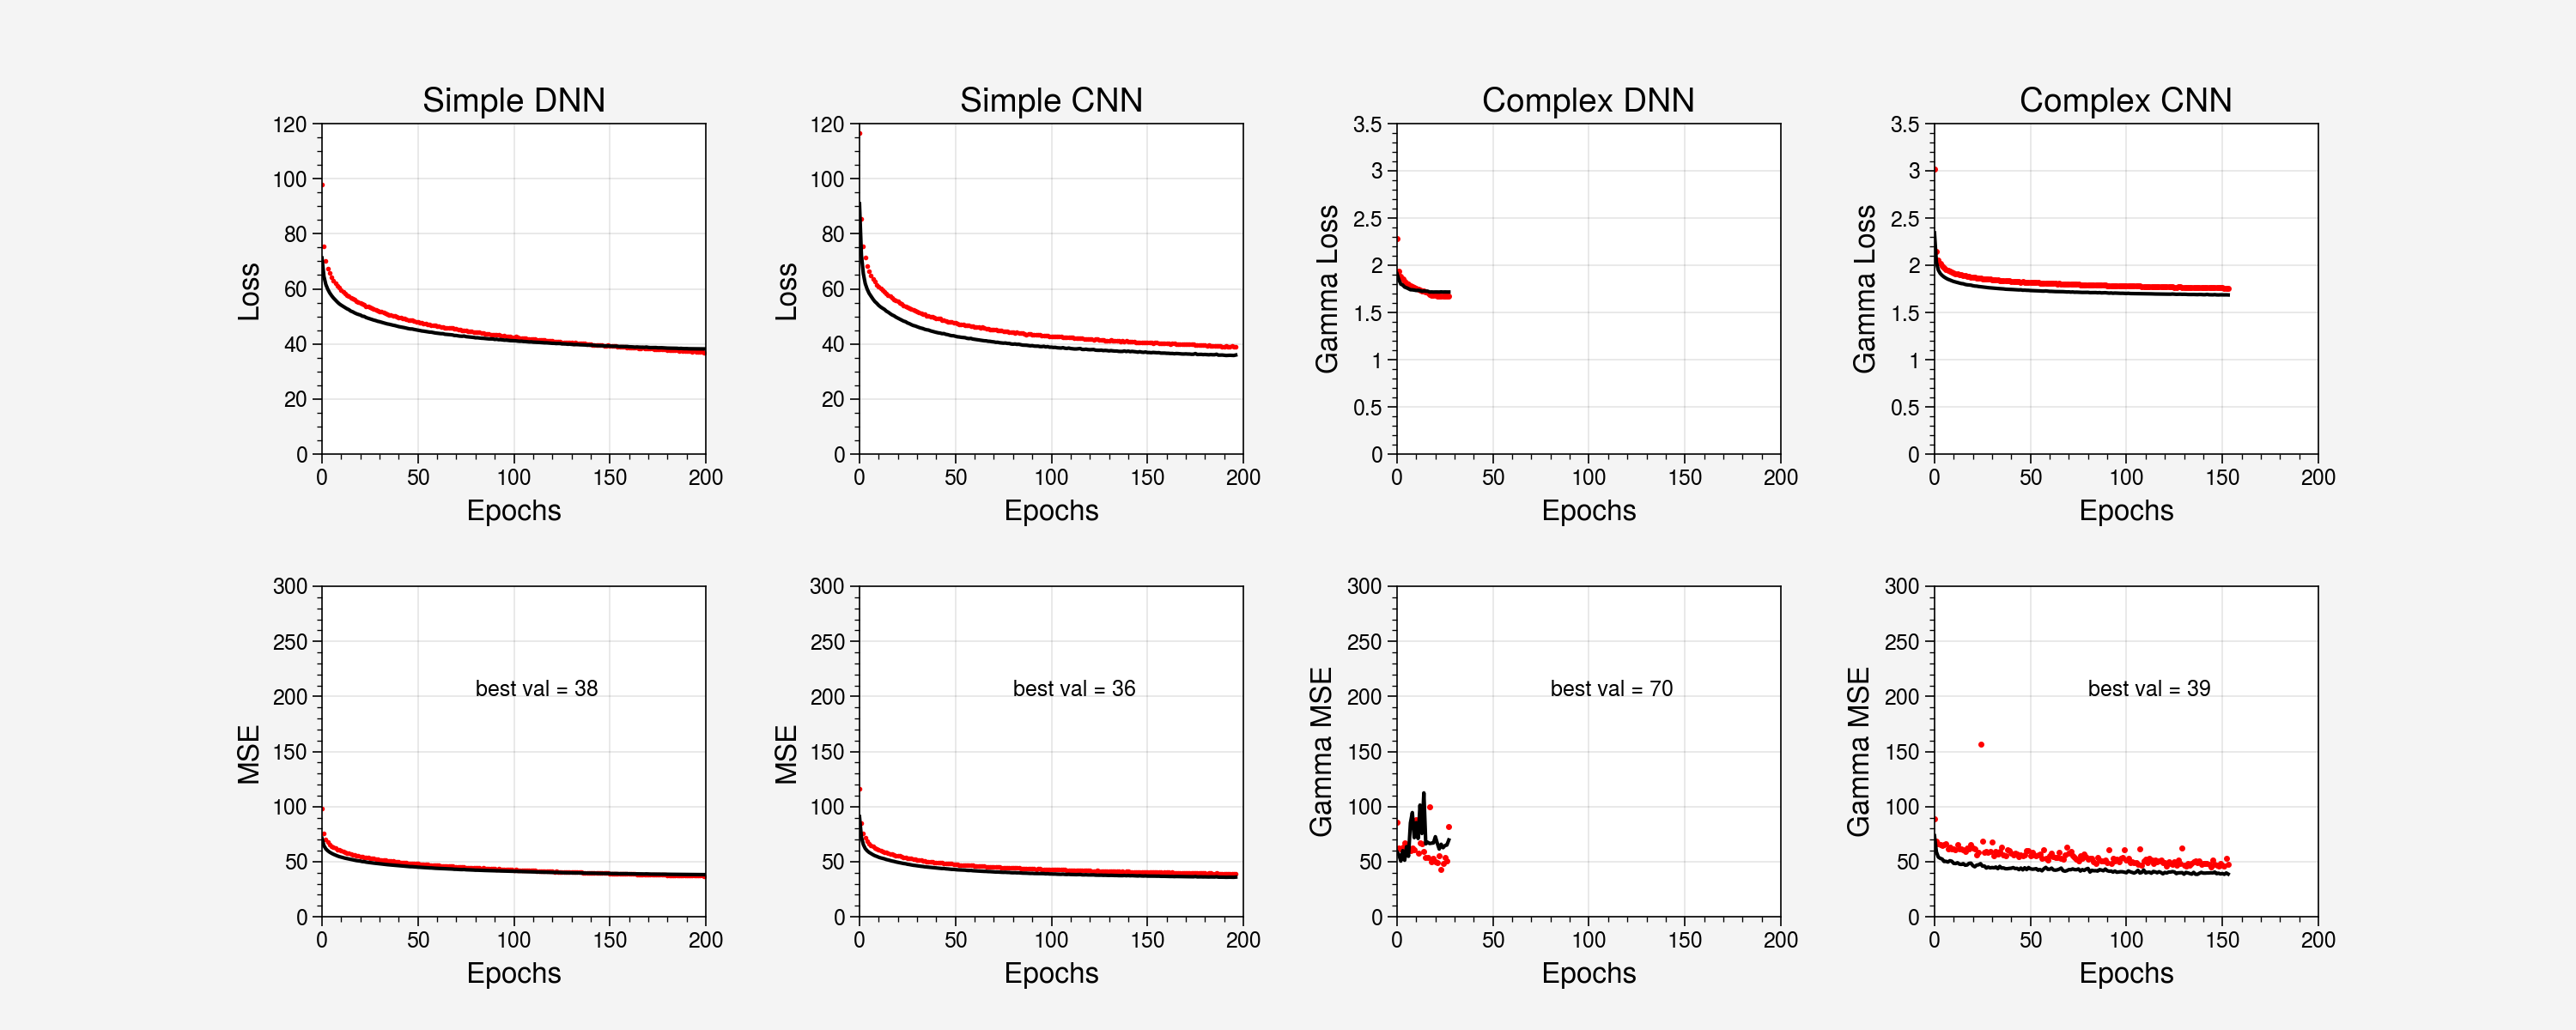

In [21]:
plt.close('all')
fig=plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 4, 1)
ax1.plot(history_sd_NZ['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_NZ['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,120)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple DNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 2)
ax1.plot(history_sc_NZ['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_NZ['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,120)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 3)
ax1.plot(history_cd_NZ['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_NZ['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,3.5)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex DNN', fontsize=14)



ax1 = fig.add_subplot(2, 4, 4)
ax1.plot(history_cc_NZ['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_NZ['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,3.5)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 5)
ax1.plot(history_sd_NZ['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_NZ['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,300)
ax1.text(80, 200,'best val = {:.0f}'.format(history_sd_NZ['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 6)
ax1.plot(history_sc_NZ['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_NZ['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,300)
ax1.text(80, 200,'best val = {:.0f}'.format(history_sc_NZ['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)


ax1 = fig.add_subplot(2, 4, 7)
ax1.plot(history_cd_NZ['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_NZ['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,300)
ax1.text(80, 200,'best val = {:.0f}'.format(history_cd_NZ['val_gamma_mse_metric'][-1]))
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 8)
ax1.plot(history_cc_NZ['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_NZ['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.text(80, 200,'best val = {:.0f}'.format(history_cc_NZ['val_gamma_mse_metric'][-1]))
ax1.set_xlim(0,200)
ax1.set_ylim(0,300)
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.legend(bbox_to_anchor = (2, 1.35),ncol = 1, fontsize=14)

plt.savefig('./Figs/histories_'+location+'.pdf',format='pdf')



Here we see that the CNN models perform the best, and the Simple CNN has the best (lowest) mean squared error.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the space dimension)

In [11]:
a=np.array(xr.corr(gt, concat_predictions.test.sel(experiments='complex_dnn'), dim=['lat', 'lon']))**2

r_squared = {
    'Complex CNN': np.array(xr.corr(gt, concat_predictions.test.sel(experiments='complex_cnn'), dim=['lat', 'lon']))**2,
    'Simple CNN': np.array(xr.corr(gt, concat_predictions.test.sel(experiments='simple_cnn'), dim=['lat', 'lon']))**2,
    'Simple DNN': np.array(xr.corr(gt, concat_predictions.test.sel(experiments='simple_dnn'), dim=['lat', 'lon']))**2,
    'Complex DNN': a[~np.isnan(a)]
}
del(a)
rmse = {
    'Complex CNN': np.sqrt(np.array((gt - concat_predictions.test.sel(experiments='complex_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple CNN': np.sqrt(np.array((gt - concat_predictions.test.sel(experiments='simple_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple DNN': np.sqrt(np.array((gt - concat_predictions.test.sel(experiments='simple_dnn')).mean(dim=['lat', 'lon']))**2),
    'Complex DNN': np.sqrt(np.array((gt - concat_predictions.test.sel(experiments='complex_dnn')).mean(dim=['lat', 'lon']))**2)
}


percentile_90 = gt.quantile(0.9)

#select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

a=np.reshape(np.array((-gt_exceeding_90th + concat_predictions.test.where(gt > percentile_90, drop=True).sel(experiments='complex_cnn'))/gt_exceeding_90th)*100,-1)
b=np.reshape(np.array((- gt_exceeding_90th + concat_predictions.test.where(gt > percentile_90, drop=True).sel(experiments='simple_cnn'))/gt_exceeding_90th)*100,-1)
c=np.reshape(np.array((- gt_exceeding_90th + concat_predictions.test.where(gt > percentile_90, drop=True).sel(experiments='simple_dnn'))/gt_exceeding_90th)*100,-1)
d=np.reshape(np.array((- gt_exceeding_90th + concat_predictions.test.where(gt > percentile_90, drop=True).sel(experiments='complex_dnn'))/gt_exceeding_90th)*100,-1)

percentthp = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': b[~np.isnan(b)],
    'Simple DNN': c[~np.isnan(c)],
    'Complex DNN': d[~np.isnan(d)]
}

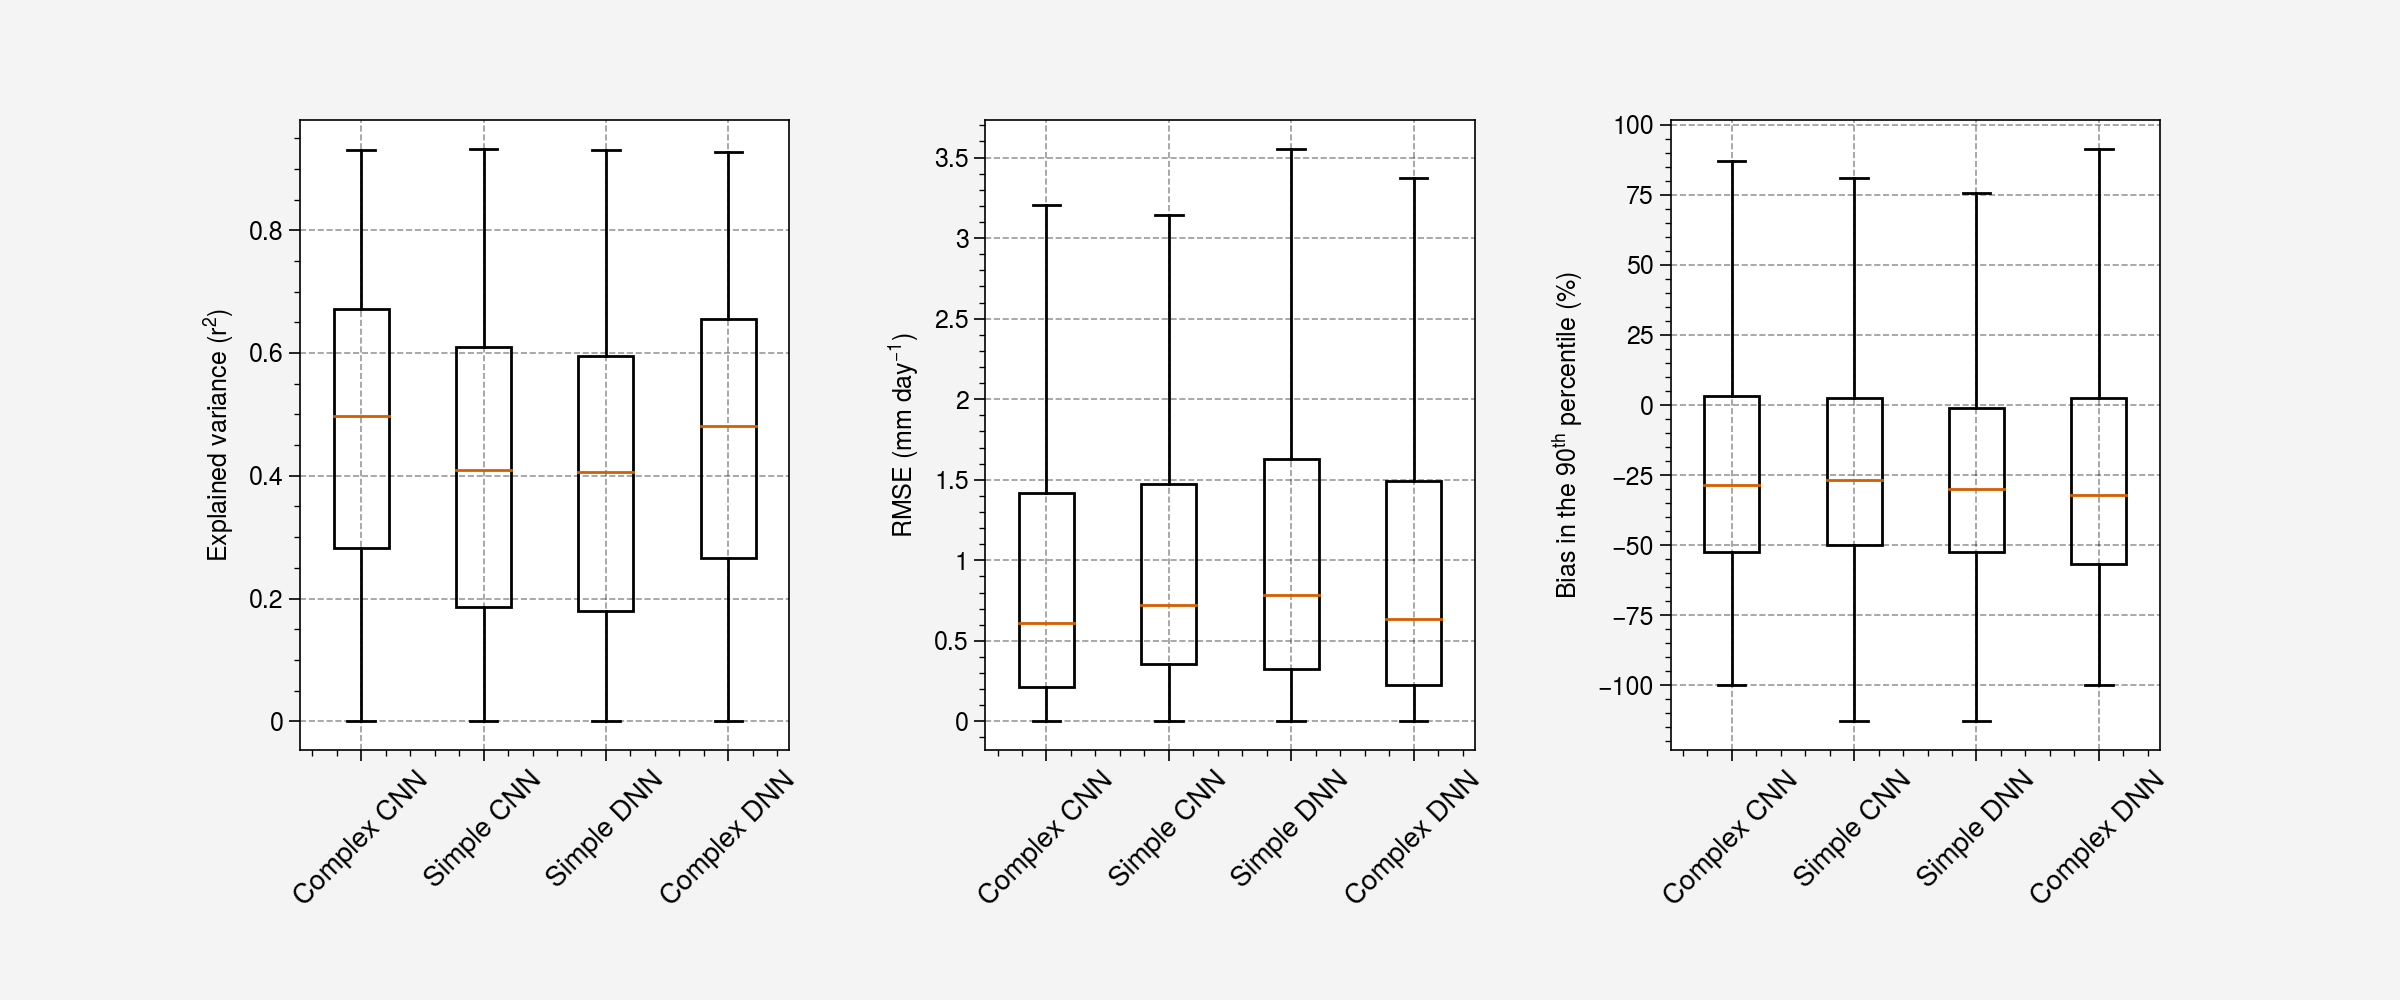

In [12]:
plt.close('all')
fig=plt.figure(1, figsize=(12,5))

ax = fig.add_subplot(1, 3, 1)
ax.boxplot(r_squared.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(r_squared.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Explained variance ($r^2$)')

ax = fig.add_subplot(1, 3, 2)
ax.boxplot(rmse.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(rmse.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'RMSE (mm day$^{-1}$)')

ax = fig.add_subplot(1, 3, 3)
ax.boxplot(percentthp.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(percentthp.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Bias in the $90^{th}$ percentile (%)')
plt.subplots_adjust(bottom=0.25, wspace=0.4)
plt.show()

Here we see that the best of all models is the CNN complex, because it has the greatest explained variance ($r^2$), the smallest RMSE (root mean square error) and a small absolute bias in the 90$^{th}$ percentile. Although, the smallest bias is from the Simple CNN model, probably because the complex models spend their ressources focused on the binary component of rainfall, which doesn't really help to simulate high intensity precipitation.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the time dimension)

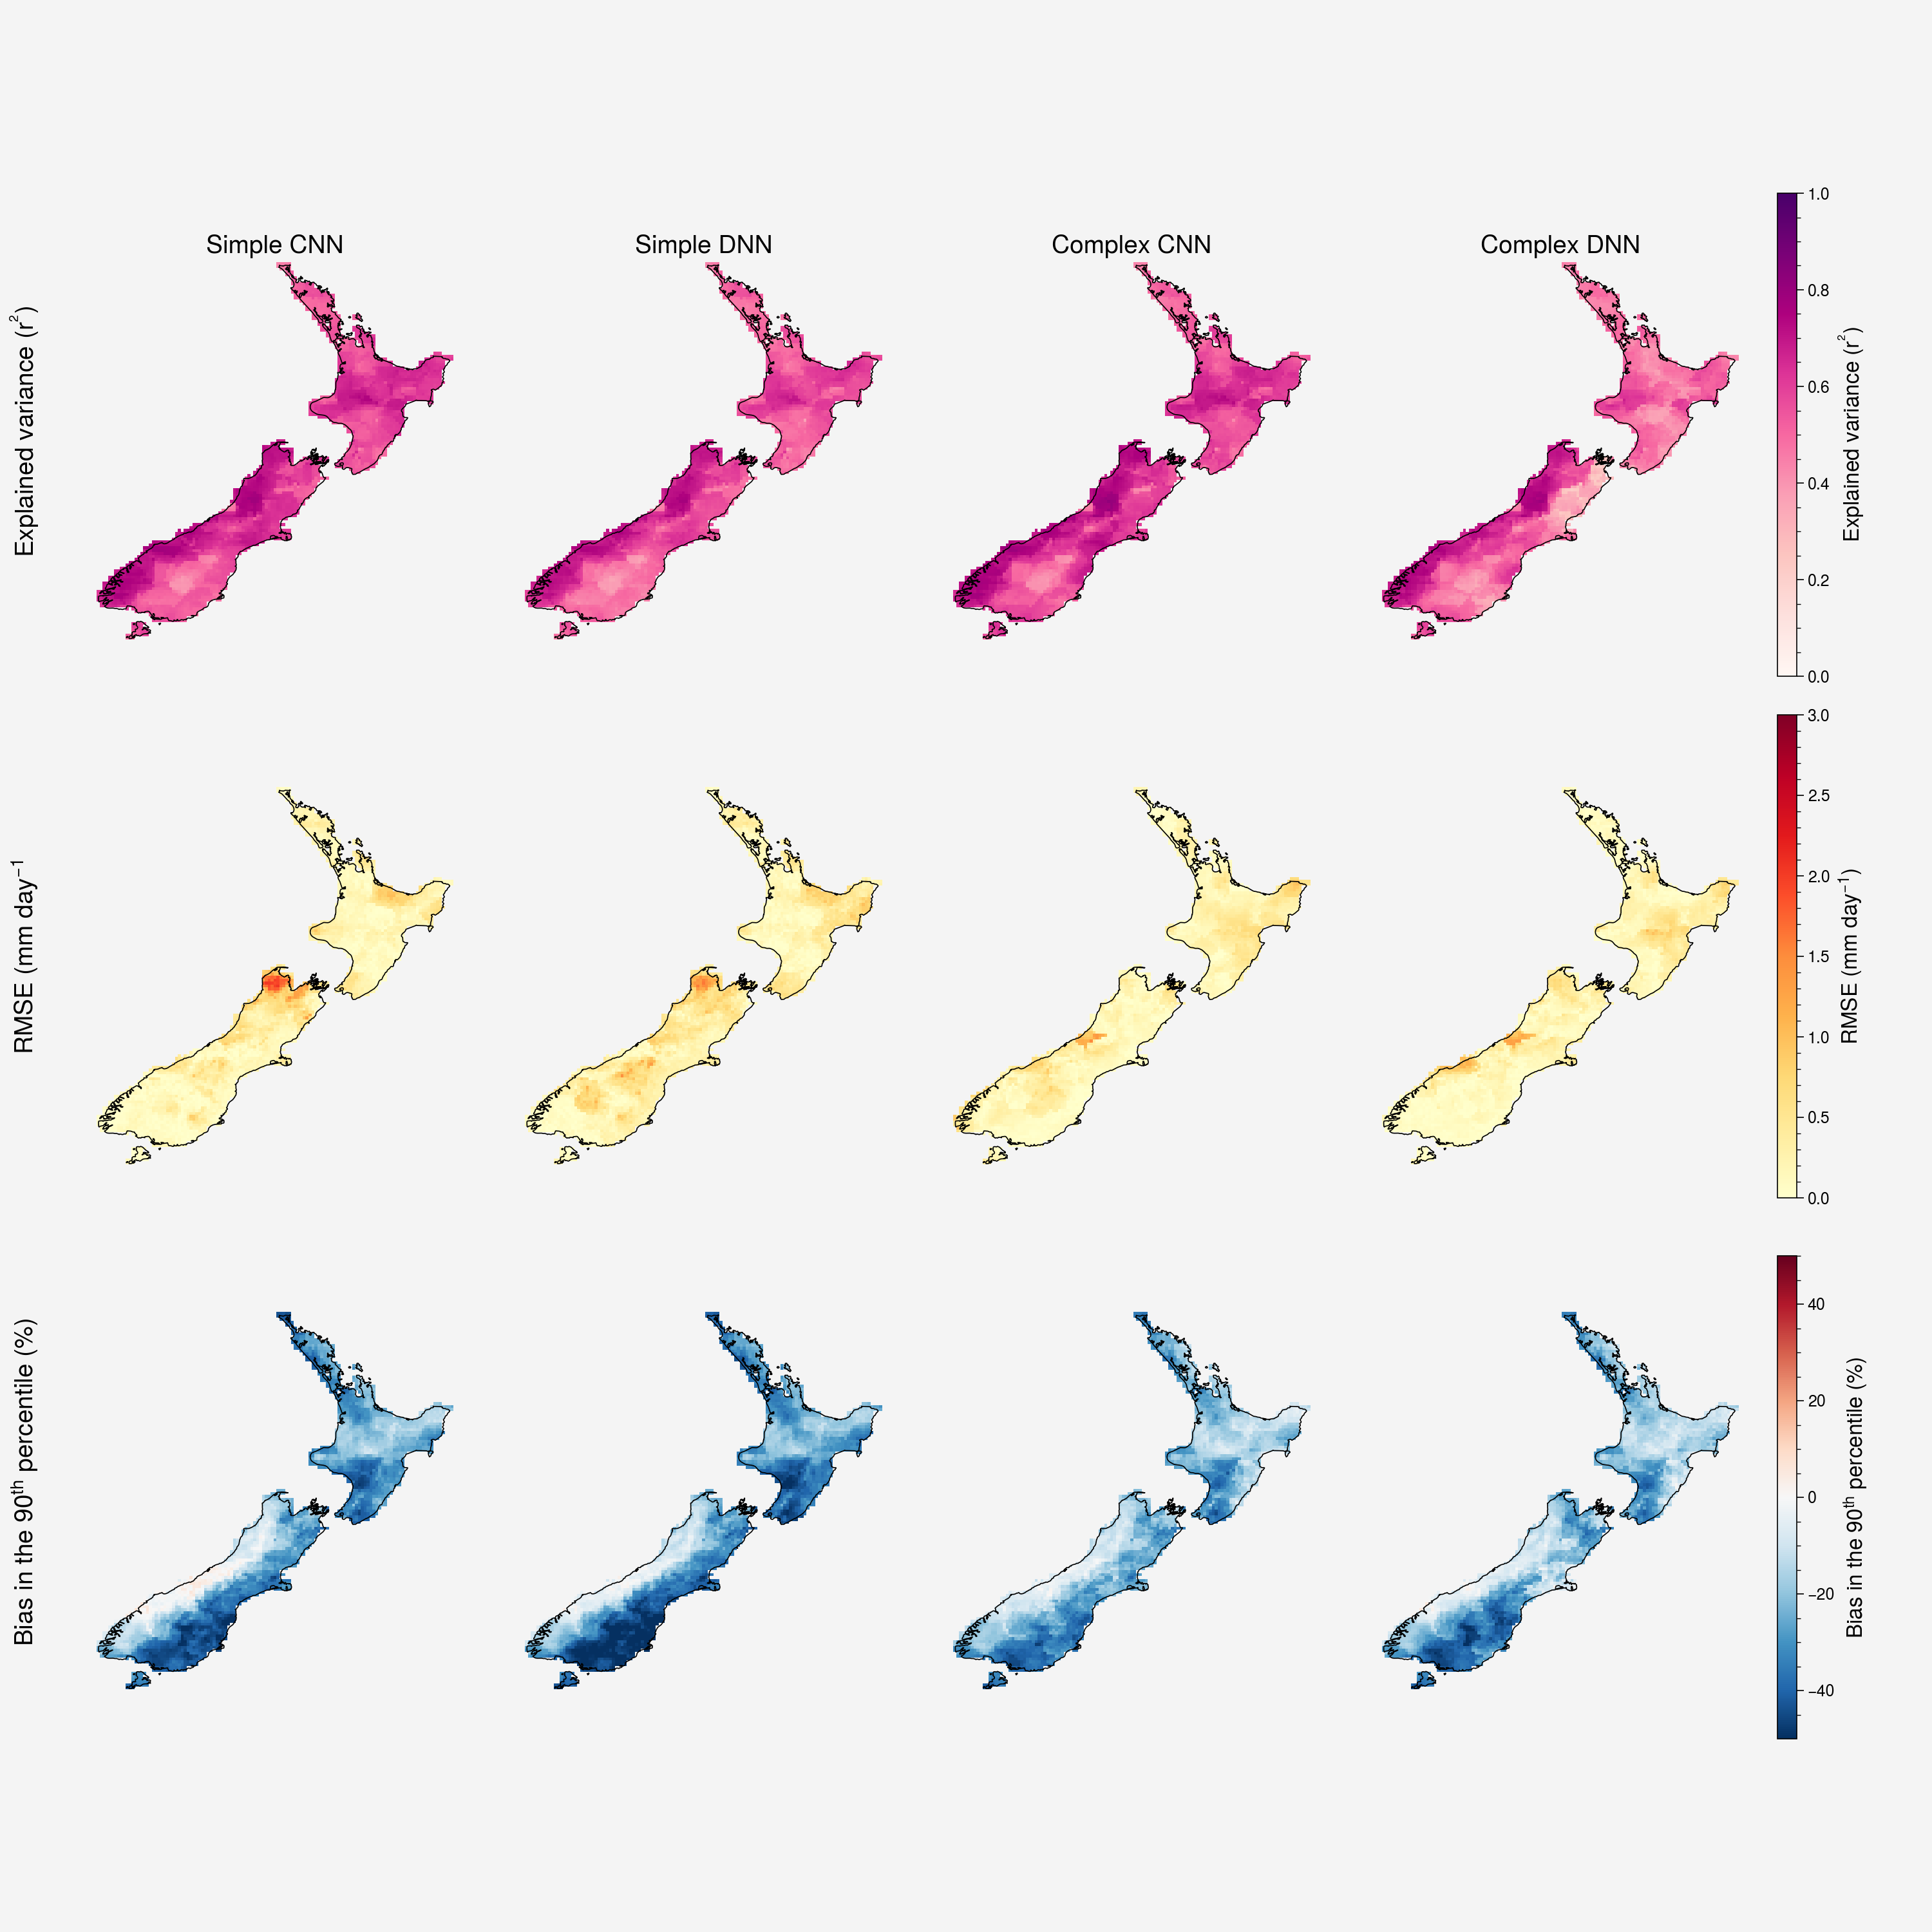

In [44]:
plt.close('all')
fig, ax = plt.subplots(3,4, figsize = (15, 15), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']

percentile_90 = gt.quantile(0.9)

# Step 2: Select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

for i in range(4):
    
    cs1 = (xr.corr(gt, concat_predictions.test.sel(experiments=exps[i]), dim=['time'])**2).plot(vmin =0, vmax =1,
                                                                            cmap ='RdPu', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            


    cs2 = np.sqrt((gt - concat_predictions.test.sel(experiments=exps[i])).mean(dim=['time'])**2).plot(vmin =0, vmax =3,
                                                                            cmap ='YlOrRd', ax = ax[i+4],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 
    
    
    
    cs3 = (((-gt_exceeding_90th + concat_predictions.test.where(gt > percentile_90, drop=True).sel(experiments=exps[i]))/gt_exceeding_90th)*100).mean(dim='time').plot(vmin =-50, vmax =50,
                                                                            cmap ='RdBu_r', ax = ax[i+8],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 


    ax[i+4].set_title('')
    ax[i+8].set_title('')
ax[0].text(-0.2, 0.55, r'Explained variance ($r^{^2}$)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[0].transAxes, fontsize=14)

ax[4].text(-0.2, 0.55, r'RMSE (mm day$^{-1}$', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[4].transAxes, fontsize=14)
   
ax[8].text(-0.2, 0.55, r'Bias in the $90^{th}$ percentile (%)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[8].transAxes, fontsize=14)
     

[axes.coastlines() for axes in ax]

ax[0].set_title('Simple CNN', fontsize=14)
ax[1].set_title('Simple DNN', fontsize=14)
ax[2].set_title('Complex CNN', fontsize=14)
ax[3].set_title('Complex DNN', fontsize=14)

[remove_spines(axes) for axes in ax]

cbar1 = fig.colorbar(cs1, cax=fig.add_axes([0.92, 0.65, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar1.set_label(r'Explained variance ($r^{^2}$)', fontsize =12)
cbar2 = fig.colorbar(cs2, cax=fig.add_axes([0.92, 0.38, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar2.set_label(r'RMSE (mm day$^{-1}$)', fontsize =12)
cbar3 = fig.colorbar(cs3, cax=fig.add_axes([0.92, 0.10, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar3.set_label(r'Bias in the $90^{th}$ percentile (%)', fontsize =12)

plt.subplots_adjust(left=0.05)
#plt.savefig('./Figs/Maps_NZ_bias_rms_r_sqrd.pdf',format='pdf')

Here, we see that spatially, the complex CNN performs the best because it has the greatest explained variance, though all models show the lowest $r^2$ inland of the South Island. The complex CNN model shows a small (< 0.5 mm day$^{-1}$) and very uniform RMSE contrary to other models; simple scheme models show a huge RMSE North West of the South Island, contrary to complex scheme models.
The complex CNN model also shows a small absolute bias in the 90$^{th}$ percentile in comparison with others. All models have a negative bias in the 90$^{th}$ percentile, especially South East of the South Island, but Complex CNN has less of a bias there.

#### Prediction Example

In [36]:
date = "2018-02-20"

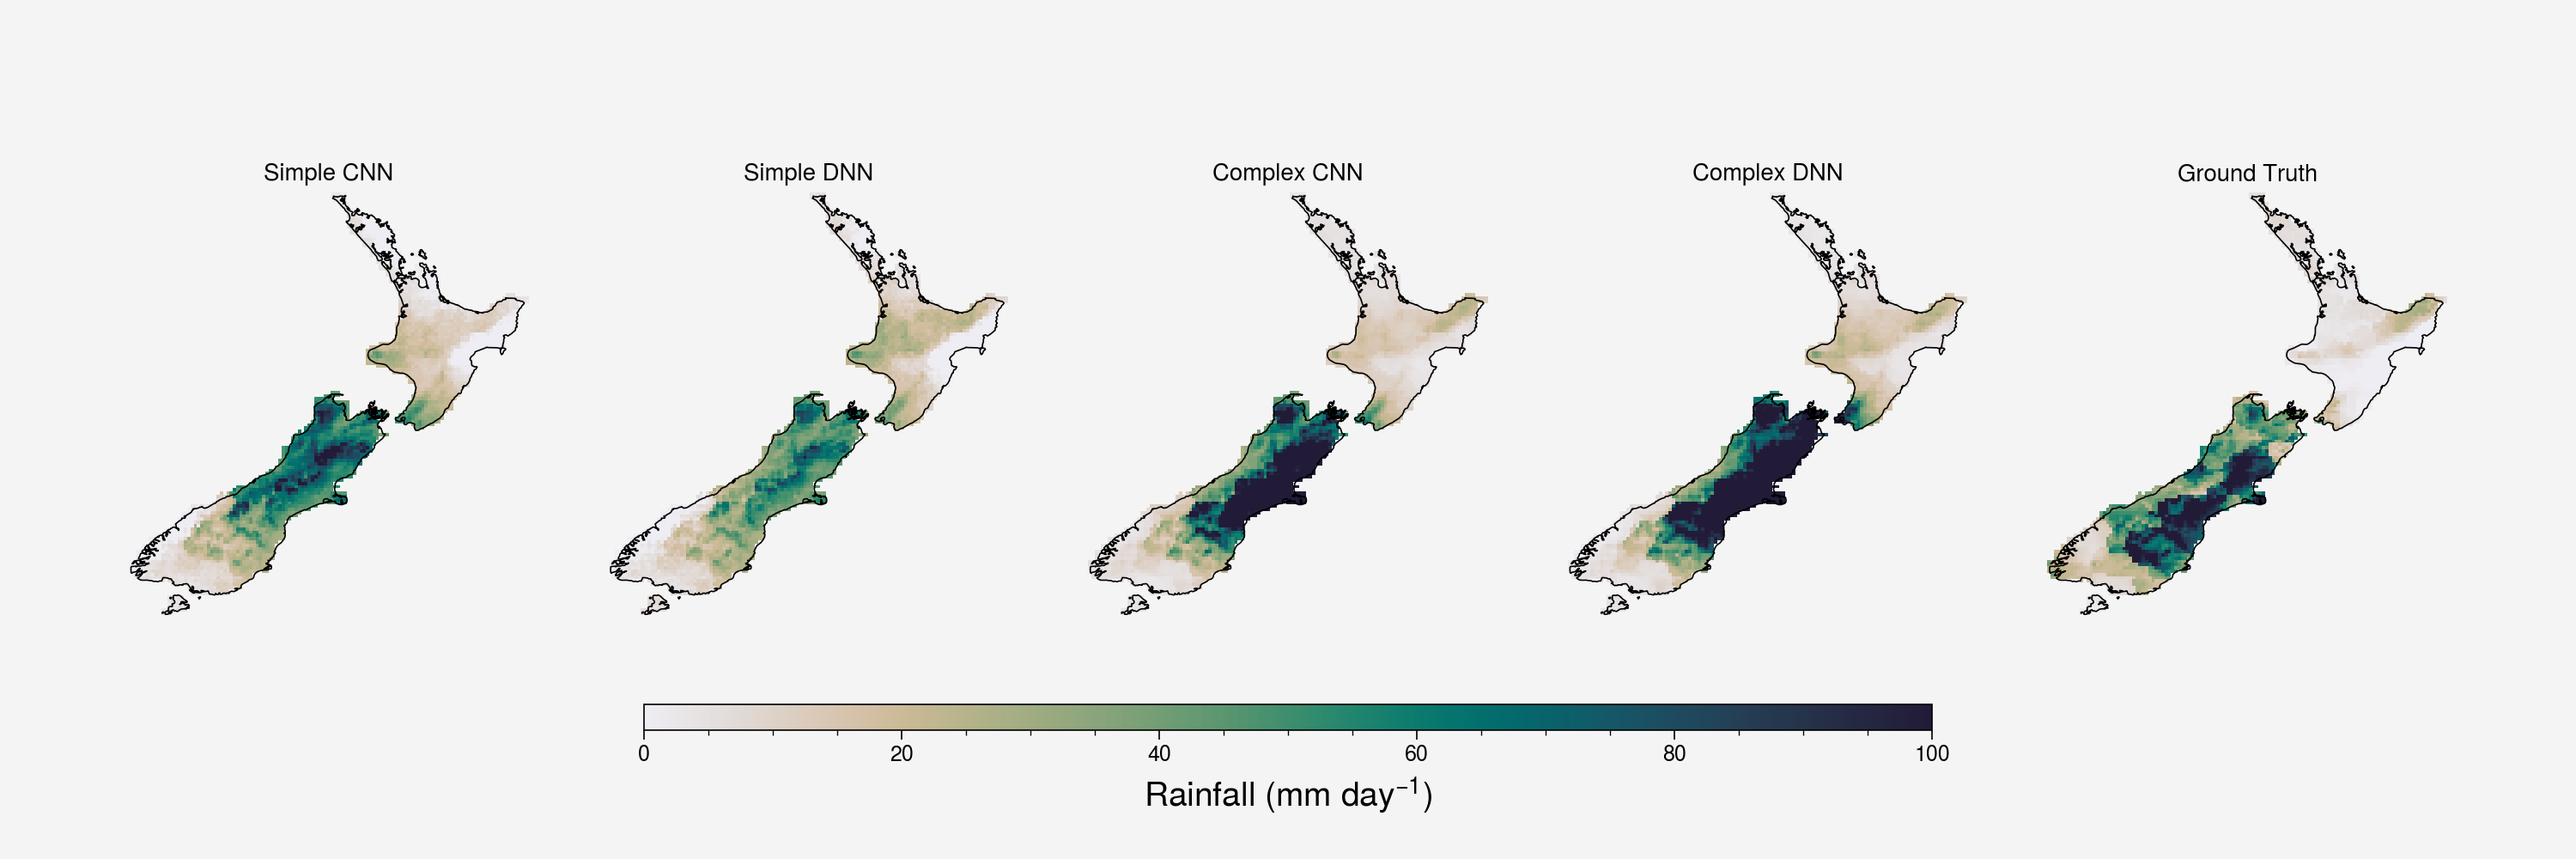

In [43]:
fig, ax = plt.subplots(1,5, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']
for i in range(4):
    concat_predictions.sel(time =date, experiments =exps[i])['test'].plot(vmin =0, vmax =100,
                                                                            cmap ='cmo.rain', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            

cs = gt.sel(time = date).plot(vmin =0, vmax =100, cmap ='cmo.rain', ax = ax[-1],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())          
[axes.set_title('') for axes in ax]
[axes.coastlines() for axes in ax]
ax4 = fig.add_axes([0.25, 0.15, 0.5, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label(r'Rainfall (mm day$^{-1}$)', fontsize =14)
ax[0].set_title('Simple CNN')
ax[1].set_title('Simple DNN')
ax[2].set_title('Complex CNN')
ax[3].set_title('Complex DNN')
ax[4].set_title('Ground Truth')

def remove_spines(ax):
    ax.set_frame_on(False)
    #fig.tight_layout()
[remove_spines(axes) for axes in ax]

plt.subplots_adjust(left=0.05, right=0.95, top=0.95)

plt.show()
#plt.savefig('./Figs/Basic_predict_maps.pdf',format='pdf')

Here, we see that, for this particular date, all models understand that rainfall hits mainly the middle/North part of the South Island. Both complex models understand the more intense rain on the East part of the Southern Alps. Overall, even if Complex CNN overestimates the amount of rainfall, it does a pretty good job at picturing this precipitation event.

## IV - Second Implementation : France (without topography added in input) <a class="anchor" id="4"></a>

In [2]:
location = 'FR'

In [3]:
config = dict(y = "./training_data/precip_FR.nc",
              X = "./training_data/ERA5_FR_no_topo.nc",
             train_start = "2000-01-01",
             train_end = "2007-01-01",
             val_start = "2007-01-02",
             val_end = "2010-01-01",
             test_start = "2010-01-02",
             test_end = "2014-12-01",
             downscale_variables = ['w_850', 'u_850',
             'v_850', 'q_850', 't_850'])

### Loading Data <a class="anchor" id="4.1"></a>

In [4]:
x_train, x_val, x_test, y_train, y_val, y_test = load_data(config)

[########################################] | 100% Completed | 633.68 ms
[########################################] | 100% Completed | 207.42 ms
[########################################] | 100% Completed | 221.78 ms
[########################################] | 100% Completed | 104.63 ms
[########################################] | 100% Completed | 324.22 ms
[########################################] | 100% Completed | 211.94 ms


### Model training hyperparameters <a class="anchor" id="4.2"></a>

In [5]:
initial_learning_rate =1e-4
dropout = 0.6
input_shape = x_train.shape[1:]
output_shape = y_train.z.size
hidden_layer_dense = 256
batch_size =64
kernel_size = 5
layer_filters =[16, 32, 64]
epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate)

In [6]:
print('Input shape is :', input_shape)
print('Output shape is :',output_shape)

Input shape is : (37, 57, 5)
Output shape is : 9171


### Compilation of the 4 models. <a class="anchor" id="4.3"></a>

In [80]:
#whether to save the models or not, they have been saved already so False
save = True

#### Simple DNN (MSE loss)

In [7]:
simple_dnn_model = simple_dnn(dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape, dropout=dropout)
#keras.utils.plot_model(simple_dnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

2024-01-15 22:22:57.685249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
if save == True : 
    simple_dnn_json = simple_dnn_model.to_json()
    with open("./wgts/simple_dnn_"+location+".json", "w") as json_file:
        json_file.write(simple_dnn_json)

#### Complex DNN ($\Gamma$ loss)

In [8]:
complex_dnn_model = complex_dnn(dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape, dropout=dropout,
                         output_shape=output_shape)
#keras.utils.plot_model(complex_dnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [84]:
if save == True : 
    complex_dnn_json = complex_dnn_model.to_json()
    with open("./wgts/complex_dnn_"+location+".json", "w") as json_file:
        json_file.write(complex_dnn_json)

#### Simple CNN (MSE loss)

In [9]:
simple_cnn_model = simple_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu')
#keras.utils.plot_model(simple_cnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [86]:
if save == True : 
    simple_cnn_json = simple_cnn_model.to_json()
    with open("./wgts/simple_cnn_"+location+".json", "w") as json_file:
        json_file.write(simple_cnn_json)

#### Complex CNN ($\Gamma$ loss)

In [10]:
complex_cnn_model = complex_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu', output_shape = output_shape)
#keras.utils.plot_model(complex_cnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [88]:
if save == True : 
    complex_cnn_json = complex_cnn_model.to_json()
    with open("./wgts/complex_cnn_"+location+".json", "w") as json_file:
        json_file.write(complex_cnn_json)

### Model Training <a class="anchor" id="4.4"></a>

In [89]:
save_hist = True

In [90]:
history_cd_FR, complex_dnn_FR = train_model(complex_dnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_dnn_' + location + '.h5',
                             metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cd_FR.history, file)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 37, 57, 5)]  0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 10545)        0           ['input_11[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 10545)        0           ['flatten_10[0][0]']             
                                                                                                  
 dense_28 (Dense)               (None, 256)          2699776     ['dropout_10[0][0]']             
                                                                                           

In [91]:
history_cc_FR, complex_cnn_FR = train_model(
complex_cnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_cnn_' + location+'.h5',
                            metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cc_FR.history, file)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 37, 57, 5)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 33, 53, 16)   2016        ['input_13[0][0]']               
                                                                                                  
 average_pooling2d_15 (AverageP  (None, 16, 26, 16)  0           ['conv2d_15[0][0]']              
 ooling2D)                                                                                        
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 26, 16)  64          ['average_pooling2d_15[0][

In [92]:
history_sd_FR, simple_dnn_FR = train_model(simple_dnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_dnn_' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sd_FR.history, file)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 37, 57, 5)]       0         
                                                                 
 flatten_9 (Flatten)         (None, 10545)             0         
                                                                 
 dropout_9 (Dropout)         (None, 10545)             0         
                                                                 
 dense_26 (Dense)            (None, 256)               2699776   
                                                                 
 dense_27 (Dense)            (None, 9171)              2356947   
                                                                 
Total params: 5,056,723
Trainable params: 5,056,723
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
40/40 [==============================

In [93]:
history_sc_FR, simple_cnn_FR = train_model(simple_cnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_cnn_' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sc_FR.history, file)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 37, 57, 5)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 33, 53, 16)        2016      
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 26, 16)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_12 (Bat  (None, 16, 26, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 22, 32)        12832     
                                                                 
 average_pooling2d_13 (Avera  (None, 6, 11, 32)        0  

### Load models with weights <a class="anchor" id="4.5"></a>

In [7]:
simple_cnn_jsonfile = open('./wgts/simple_cnn_'+location+'.json', 'r')
simple_cnn_test_json = simple_cnn_jsonfile.read()
simple_cnn_jsonfile.close()
simple_cnn = model_from_json(simple_cnn_test_json)
# load weights into new model
simple_cnn.load_weights('./wgts/simple_cnn_' + location + '.h5')
print("Loaded model from disk")


complex_cnn_jsonfile = open('./wgts/complex_cnn_'+location+'.json', 'r')
complex_cnn_test_json = complex_cnn_jsonfile.read()
complex_cnn_jsonfile.close()
complex_cnn = model_from_json(complex_cnn_test_json)
# load weights into new model
complex_cnn.load_weights('./wgts/complex_cnn_' + location + '.h5')
print("Loaded model from disk")
#DNN

simple_dnn_jsonfile = open('./wgts/simple_dnn_'+location+'.json', 'r')
simple_dnn_test_json = simple_dnn_jsonfile.read()
simple_dnn_jsonfile.close()
simple_dnn = model_from_json(simple_dnn_test_json)
# load weights into new model
simple_dnn.load_weights('./wgts/simple_dnn_' + location + '.h5')
print("Loaded model from disk")


complex_dnn_jsonfile = open('./wgts/complex_dnn_'+location+'.json', 'r')
complex_dnn_test_json = complex_dnn_jsonfile.read()
complex_dnn_jsonfile.close()
complex_dnn = model_from_json(complex_dnn_test_json)
# load weights into new model
complex_dnn.load_weights('./wgts/complex_dnn_' + location + '.h5')
print("Loaded model from disk")

2024-01-16 10:27:25.145867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


### Inference <a class="anchor" id="4.6"></a>

In [8]:
simple_cnn_prediction = infer(simple_cnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
simple_dnn_prediction = infer(simple_dnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
complex_cnn_prediction = infer(complex_cnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)
complex_dnn_prediction = infer(complex_dnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)

concat_predictions_FR = xr.concat([simple_cnn_prediction, simple_dnn_prediction,complex_cnn_prediction, complex_dnn_prediction], dim ="experiments")
concat_predictions_FR['experiments'] = (('experiments'),['simple_cnn','simple_dnn', 'complex_cnn', 'complex_dnn'])

gt = y_test.unstack()
gt = gt.reindex(lon = sorted(gt.lon.values))

50/50 [==============================] - 0s 7ms/step


### Performance analysis <a class="anchor" id="4.7"></a>

In this part, I analyze how the models perform.

#### Loss and MSE during training

In this part, I load the history, so I don't have to re-train the models (which is very long), so they must have been saved beforehand.

In [13]:
with open('./hist/history_sd_' + location + '.pkl', 'rb') as file:
    history_sd_FR = pickle.load(file)
    
with open('./hist/history_sc_' + location + '.pkl', 'rb') as file:
    history_sc_FR = pickle.load(file)
    
with open('./hist/history_cc_' + location + '.pkl', 'rb') as file:
    history_cc_FR = pickle.load(file)
    
with open('./hist/history_cd_' + location + '.pkl', 'rb') as file:
    history_cd_FR = pickle.load(file)

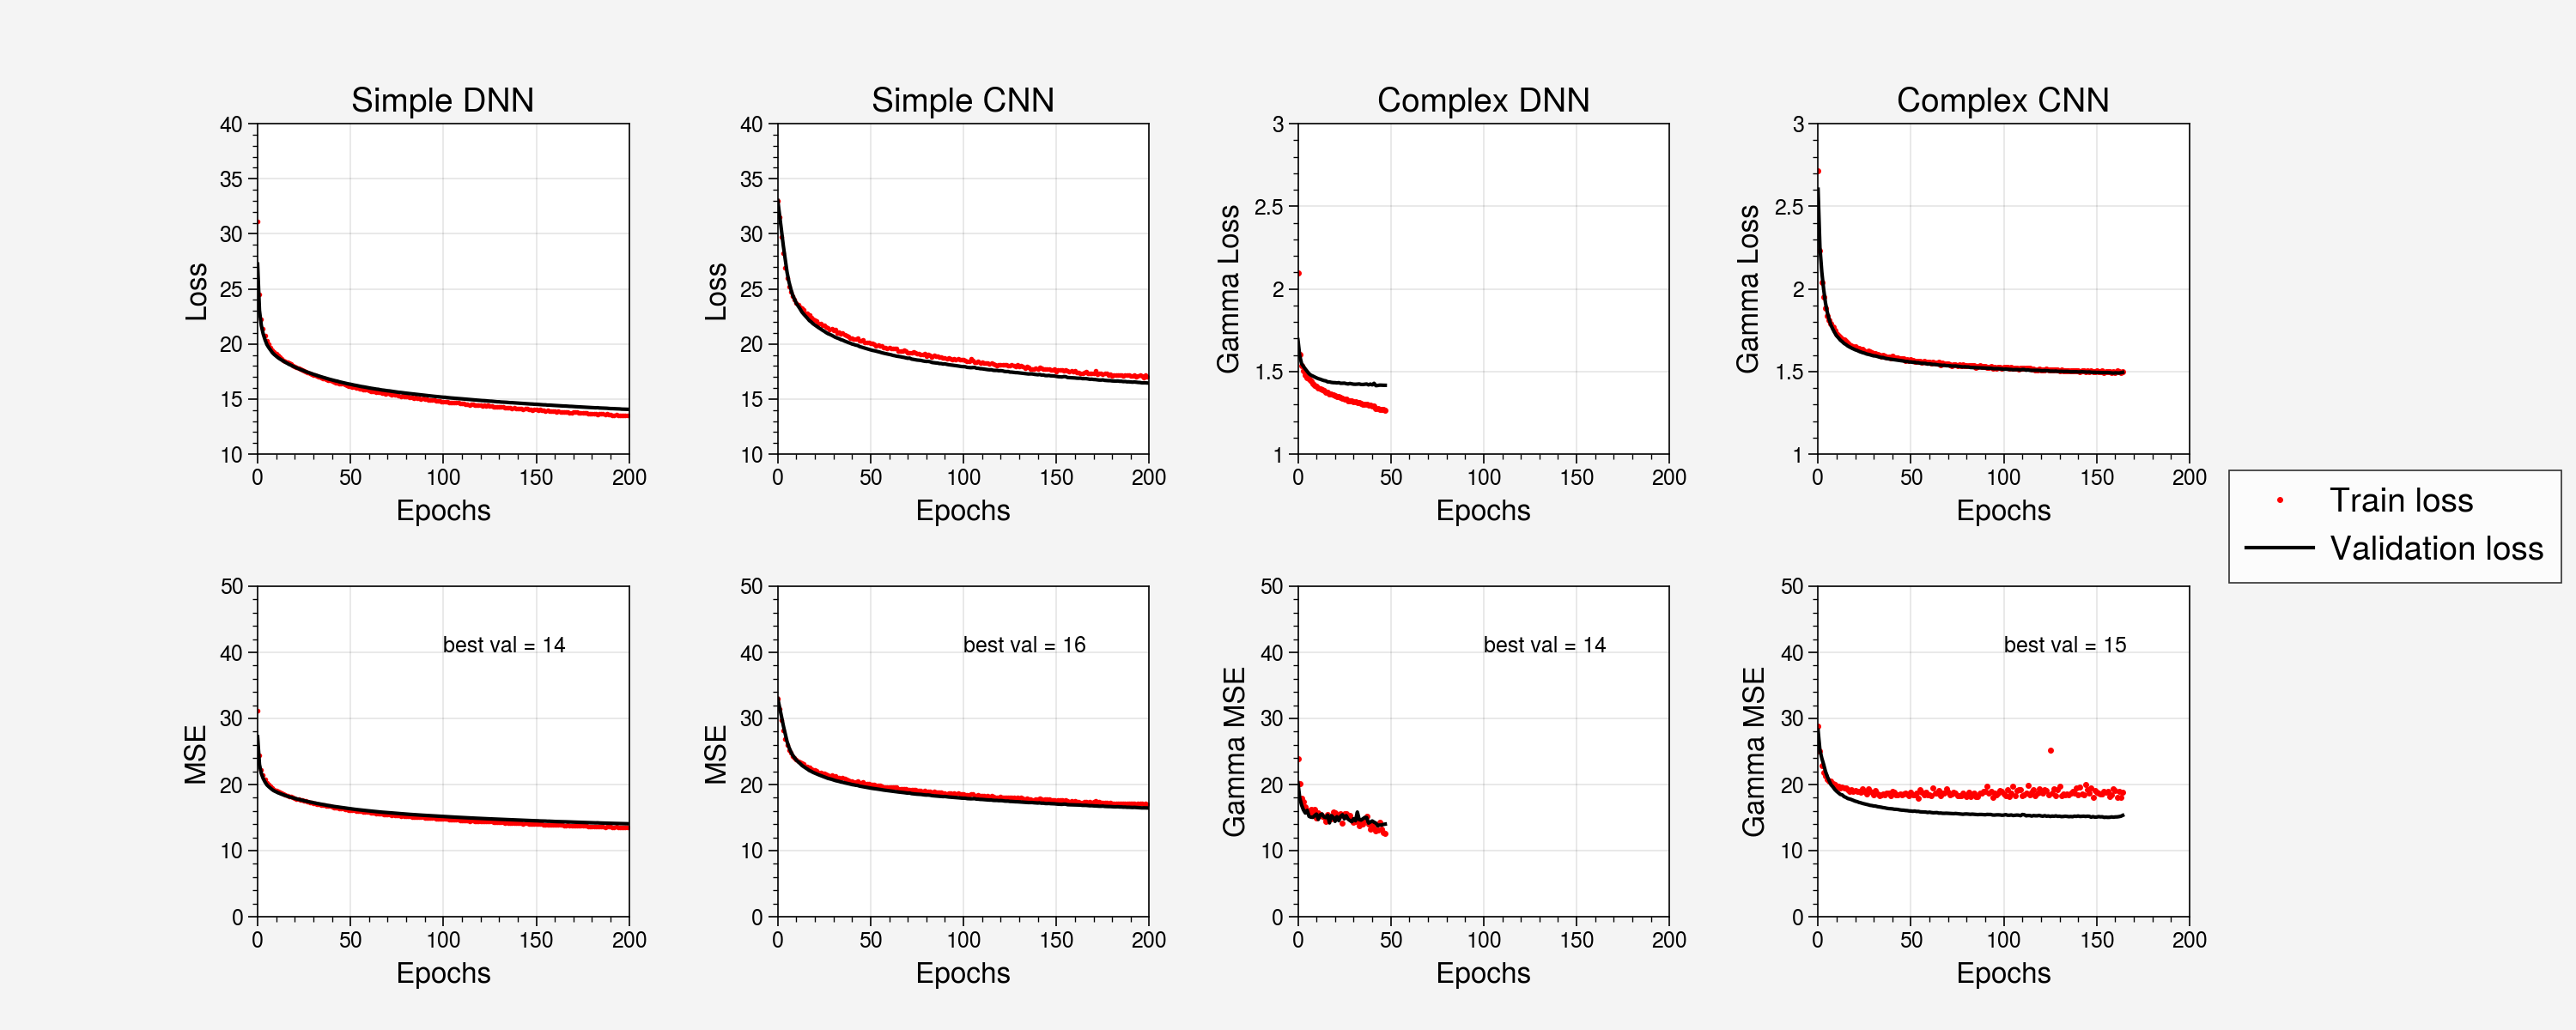

In [18]:
plt.close('all')
fig=plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 4, 1)
ax1.plot(history_sd_FR['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_FR['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(10,40)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple DNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 2)
ax1.plot(history_sc_FR['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_FR['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(10,40)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 3)
ax1.plot(history_cd_FR['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_FR['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(1,3)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex DNN', fontsize=14)



ax1 = fig.add_subplot(2, 4, 4)
ax1.plot(history_cc_FR['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_FR['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(1,3)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 5)
ax1.plot(history_sd_FR['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_FR['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_sd_FR['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 6)
ax1.plot(history_sc_FR['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_FR['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_sc_FR['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)


ax1 = fig.add_subplot(2, 4, 7)
ax1.plot(history_cd_FR['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_FR['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_cd_FR['val_gamma_mse_metric'][-1]))
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 8)
ax1.plot(history_cc_FR['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_FR['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.text(100, 40,'best val = {:.0f}'.format(history_cc_FR['val_gamma_mse_metric'][-1]))
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

plt.subplots_adjust(left = 0.1, right=0.85,hspace=0.4, wspace=0.4)
plt.legend(bbox_to_anchor = (2, 1.35),ncol = 1, fontsize=14)
plt.show()
#plt.savefig('./Figs/histories_'+location+'.pdf',format='pdf')


Here we see that contrary to New Zealand, the best performing models seem to be the two DNN ones. Which is very surprising because a spatial data such as precipitation is spatially correlated, therefore we would expect a CNN taking into acount the spatial pattern and correlation to be better.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the space dimension)

In [129]:
a = np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='complex_cnn'), dim=['lat', 'lon']))**2
b = np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='complex_dnn'), dim=['lat', 'lon']))**2
r_squared = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='simple_cnn'), dim=['lat', 'lon']))**2,
    'Simple DNN': np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='simple_dnn'), dim=['lat', 'lon']))**2,
    'Complex DNN': b[~np.isnan(b)]
}
del(a,b)

rmse = {
    'Complex CNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='complex_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple CNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='simple_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple DNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='simple_dnn')).mean(dim=['lat', 'lon']))**2),
    'Complex DNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='complex_dnn')).mean(dim=['lat', 'lon']))**2)
}


percentile_90 = gt.quantile(0.9)

#select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

a=np.reshape(np.array((-gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='complex_cnn'))/gt_exceeding_90th)*100,-1)
b=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='simple_cnn'))/gt_exceeding_90th)*100,-1)
c=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='simple_dnn'))/gt_exceeding_90th)*100,-1)
d=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='complex_dnn'))/gt_exceeding_90th)*100,-1)

percentthp = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': b[~np.isnan(b)],
    'Simple DNN': c[~np.isnan(c)],
    'Complex DNN': d[~np.isnan(d)]
}

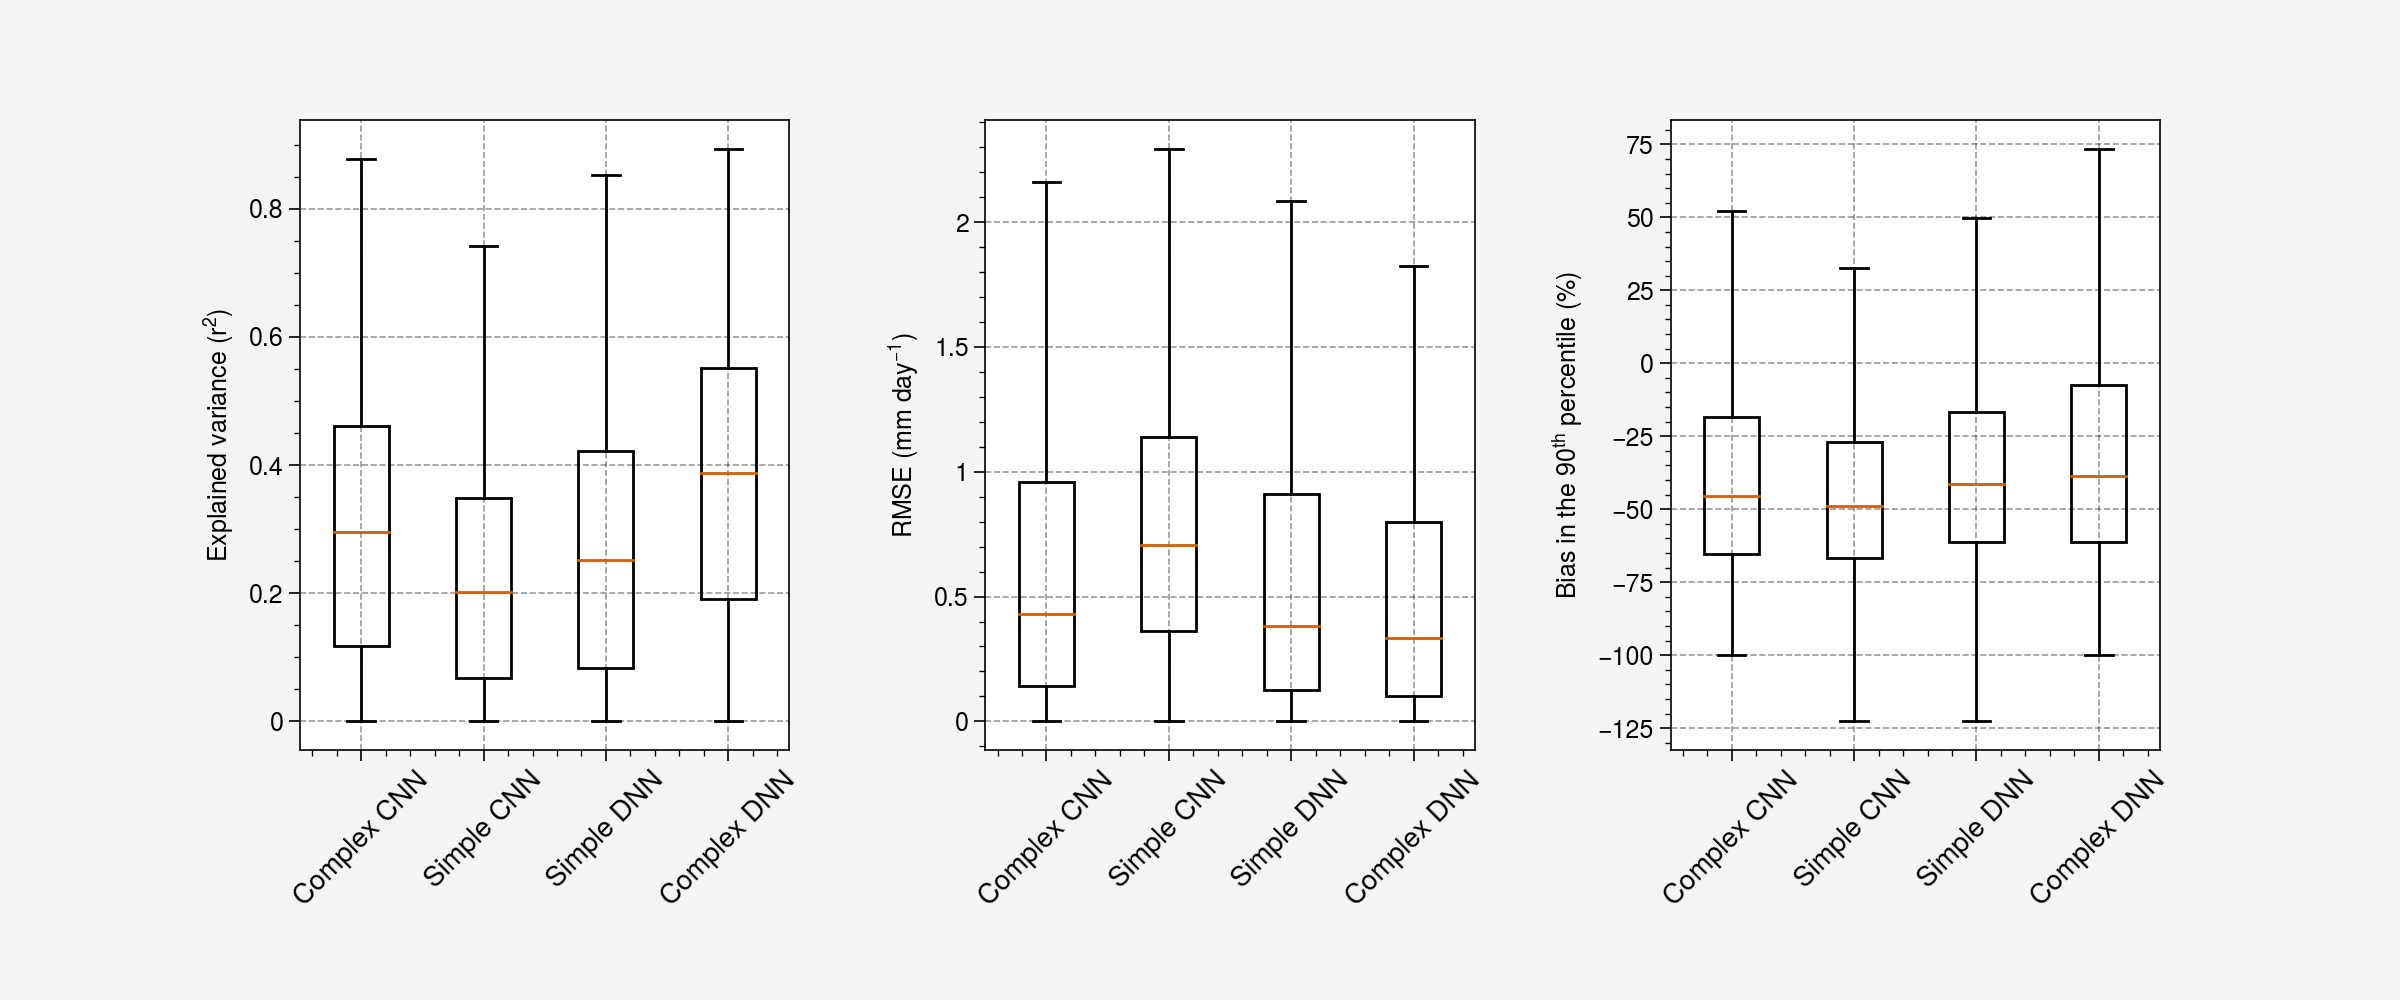

In [130]:
plt.close('all')
fig=plt.figure(1, figsize=(12,5))

ax = fig.add_subplot(1, 3, 1)
ax.boxplot(r_squared.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(r_squared.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Explained variance ($r^2$)')

ax = fig.add_subplot(1, 3, 2)
ax.boxplot(rmse.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(rmse.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'RMSE (mm day$^{-1}$)')

ax = fig.add_subplot(1, 3, 3)
ax.boxplot(percentthp.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(percentthp.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Bias in the $90^{th}$ percentile (%)')
plt.subplots_adjust(bottom=0.25, wspace=0.4)
plt.show()

Here we see that the overall best model is the Complex DNN, because it has the greatest explained variance ($r^2$), the smallest RMSE (root mean square error) and the smallest absolute bias in the 90$^{th}$ percentile.
I would guess that the reason the Complex CNN one is not the best for France, is because of its complex topography and it complex localisation, on the path of westerlies coming from the Atlantic, but also surrounded by land on the Southwest, Southeast and mostly East, contrary to New Zealand which has also a complex topography, but is an island in the middle of the ocean.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the time dimension)

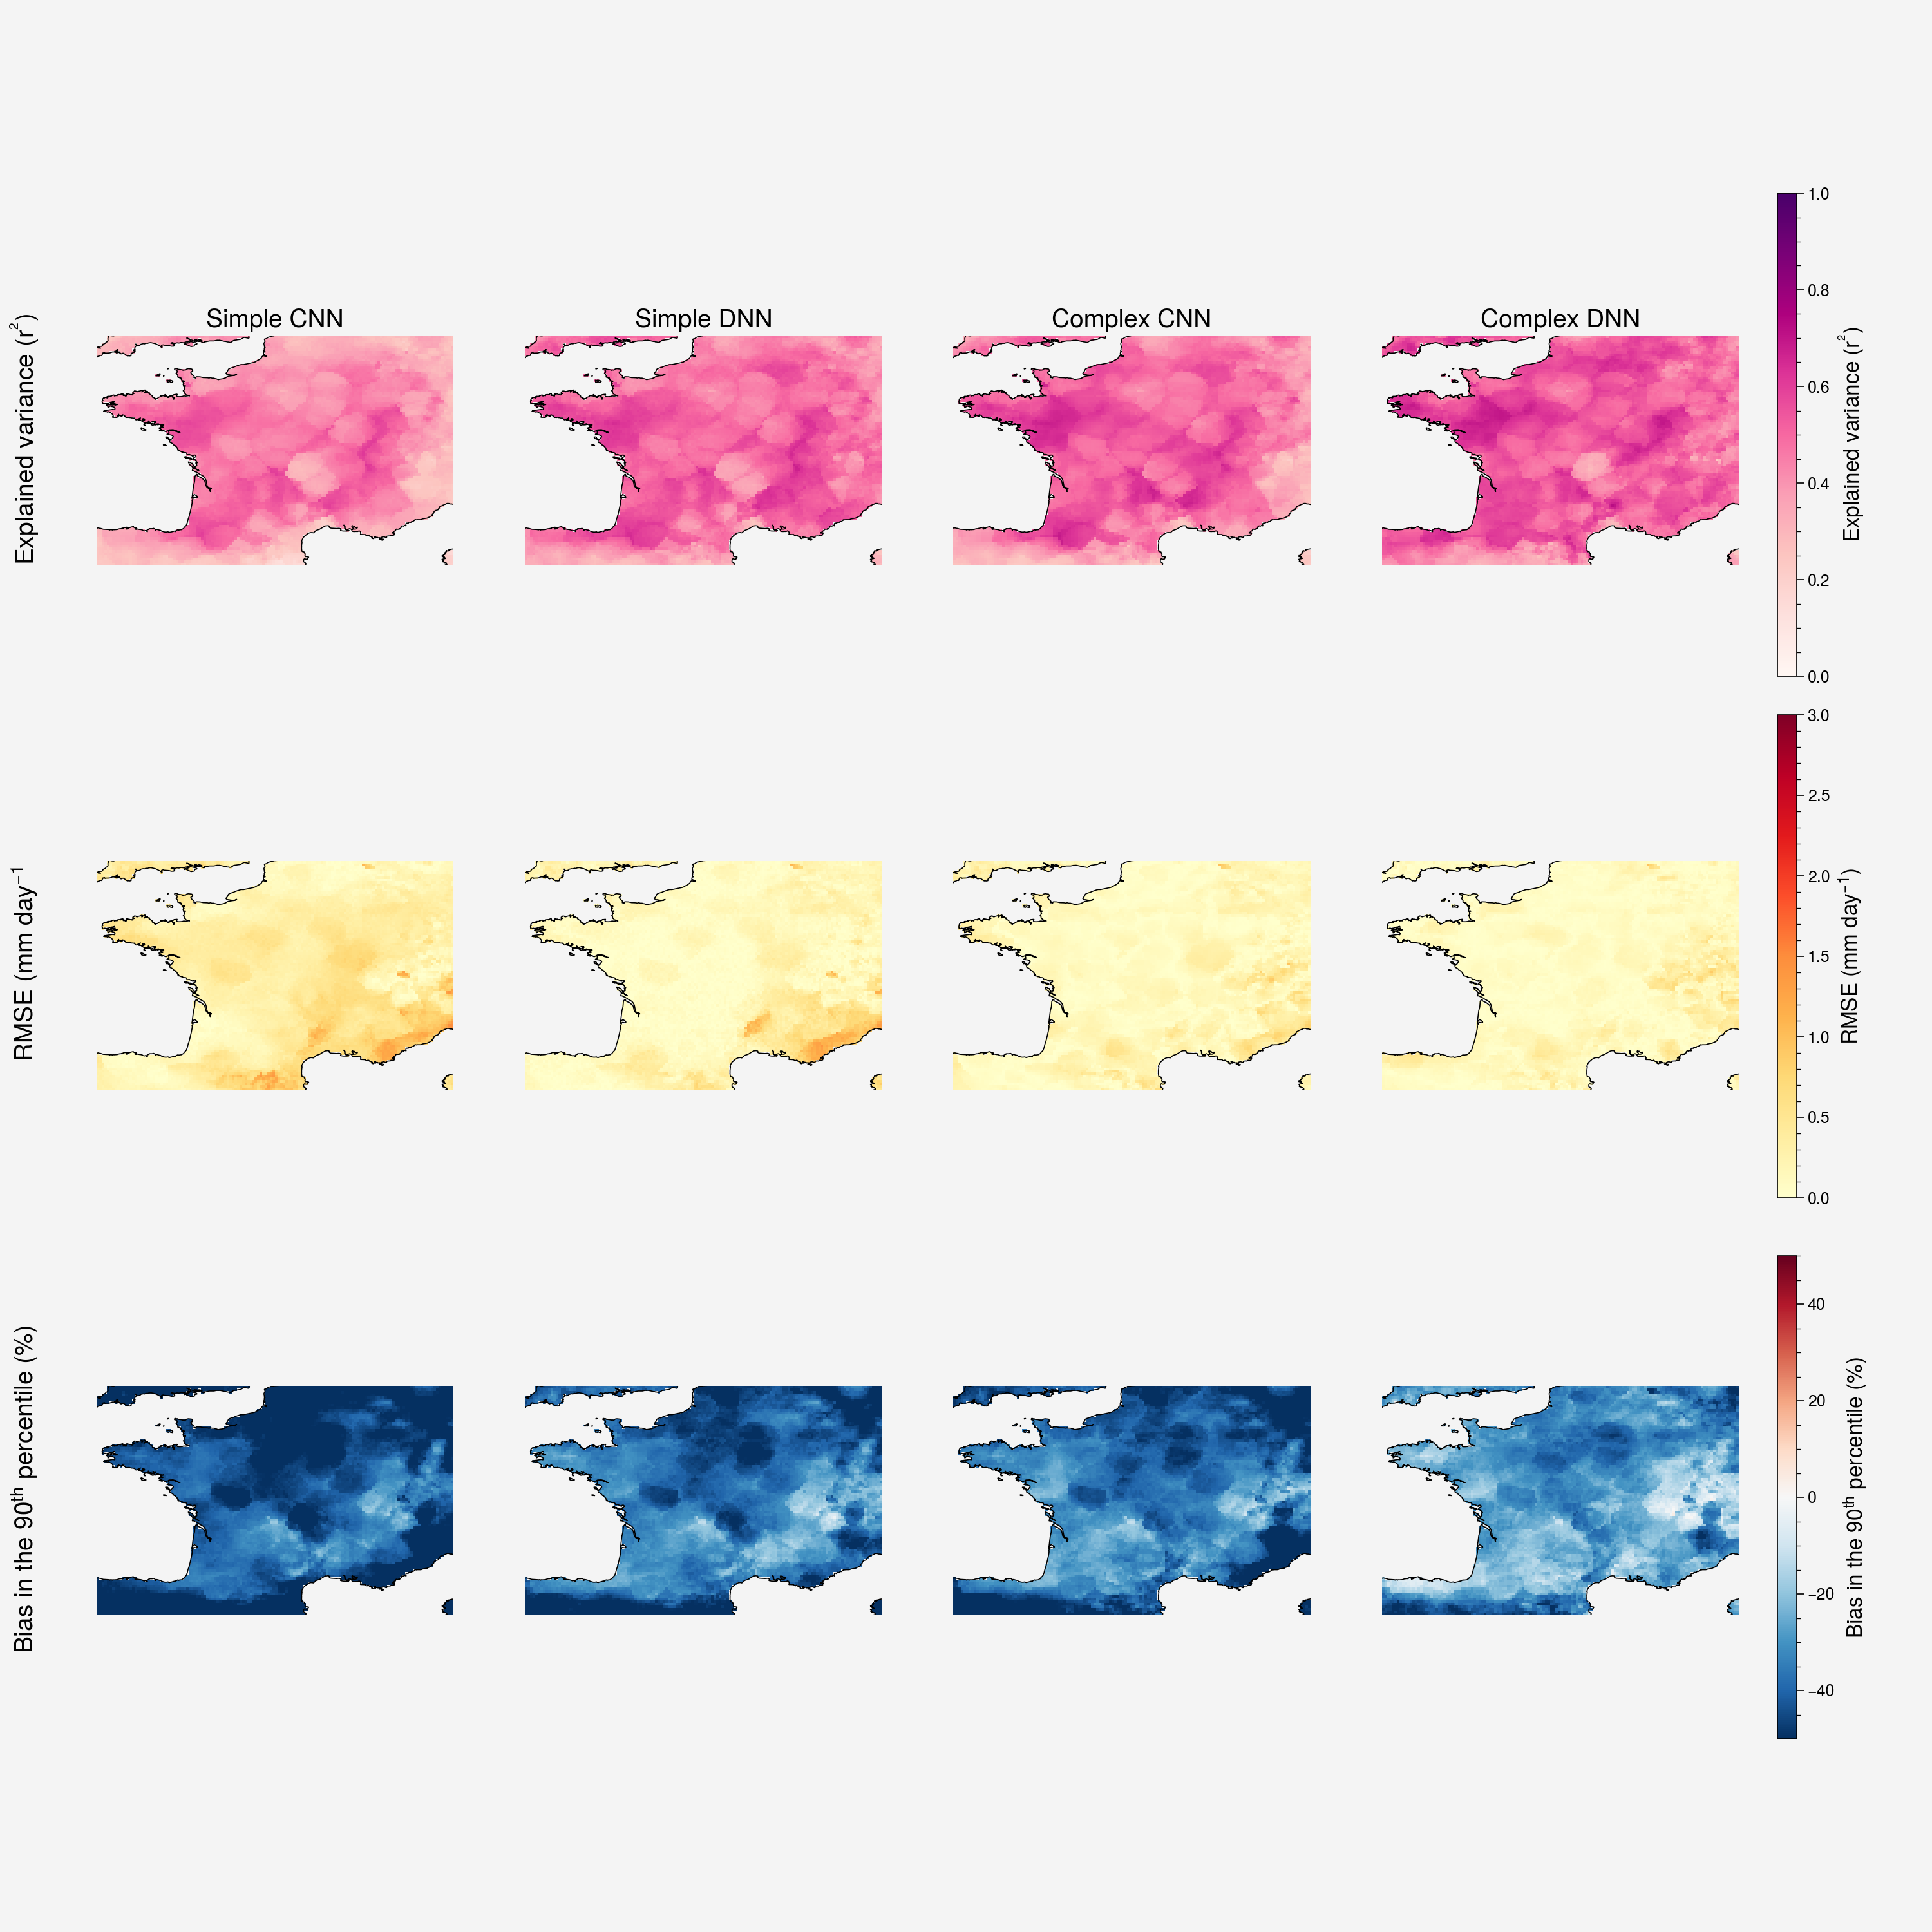

In [131]:
plt.close('all')
fig, ax = plt.subplots(3,4, figsize = (15, 15), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']

percentile_90 = gt.quantile(0.9)

# Step 2: Select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

for i in range(4):
    
    cs1 = (xr.corr(gt, concat_predictions_FR.test.sel(experiments=exps[i]), dim=['time'])**2).plot(vmin =0, vmax =1,
                                                                            cmap ='RdPu', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            


    cs2 = np.sqrt((gt - concat_predictions_FR.test.sel(experiments=exps[i])).mean(dim=['time'])**2).plot(vmin =0, vmax =3,
                                                                            cmap ='YlOrRd', ax = ax[i+4],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 
    
    
    
    cs3 = (((-gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments=exps[i]))/gt_exceeding_90th)*100).mean(dim='time').plot(vmin =-50, vmax =50,
                                                                            cmap ='RdBu_r', ax = ax[i+8],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 


    ax[i+4].set_title('')
    ax[i+8].set_title('')
ax[0].text(-0.2, 0.55, r'Explained variance ($r^{^2}$)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[0].transAxes, fontsize=14)

ax[4].text(-0.2, 0.55, r'RMSE (mm day$^{-1}$', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[4].transAxes, fontsize=14)
   
ax[8].text(-0.2, 0.55, r'Bias in the $90^{th}$ percentile (%)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[8].transAxes, fontsize=14)
     

[axes.coastlines() for axes in ax]

ax[0].set_title('Simple CNN', fontsize=14)
ax[1].set_title('Simple DNN', fontsize=14)
ax[2].set_title('Complex CNN', fontsize=14)
ax[3].set_title('Complex DNN', fontsize=14)

[remove_spines(axes) for axes in ax]

cbar1 = fig.colorbar(cs1, cax=fig.add_axes([0.92, 0.65, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar1.set_label(r'Explained variance ($r^{^2}$)', fontsize =12)
cbar2 = fig.colorbar(cs2, cax=fig.add_axes([0.92, 0.38, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar2.set_label(r'RMSE (mm day$^{-1}$)', fontsize =12)
cbar3 = fig.colorbar(cs3, cax=fig.add_axes([0.92, 0.10, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar3.set_label(r'Bias in the $90^{th}$ percentile (%)', fontsize =12)

plt.subplots_adjust(left=0.05)
#plt.savefig('./Figs/Maps_NZ_bias_rms_r_sqrd.pdf',format='pdf')

Here also, we see that the Complex DNN model is the best overall. But what I notice the most is the patchy pattern on the whole country, for all models, there seems to be not spatial understanding of the models, indicating a lack in the knowledge of the topography.
Also, the bias in the 90$^{th}$ percentile is huge (around 50% lower) : there is a flaw in predicting high intensity precipitation, same as for New Zealand.

#### Prediction example 

In [59]:
date = "2010-11-20"

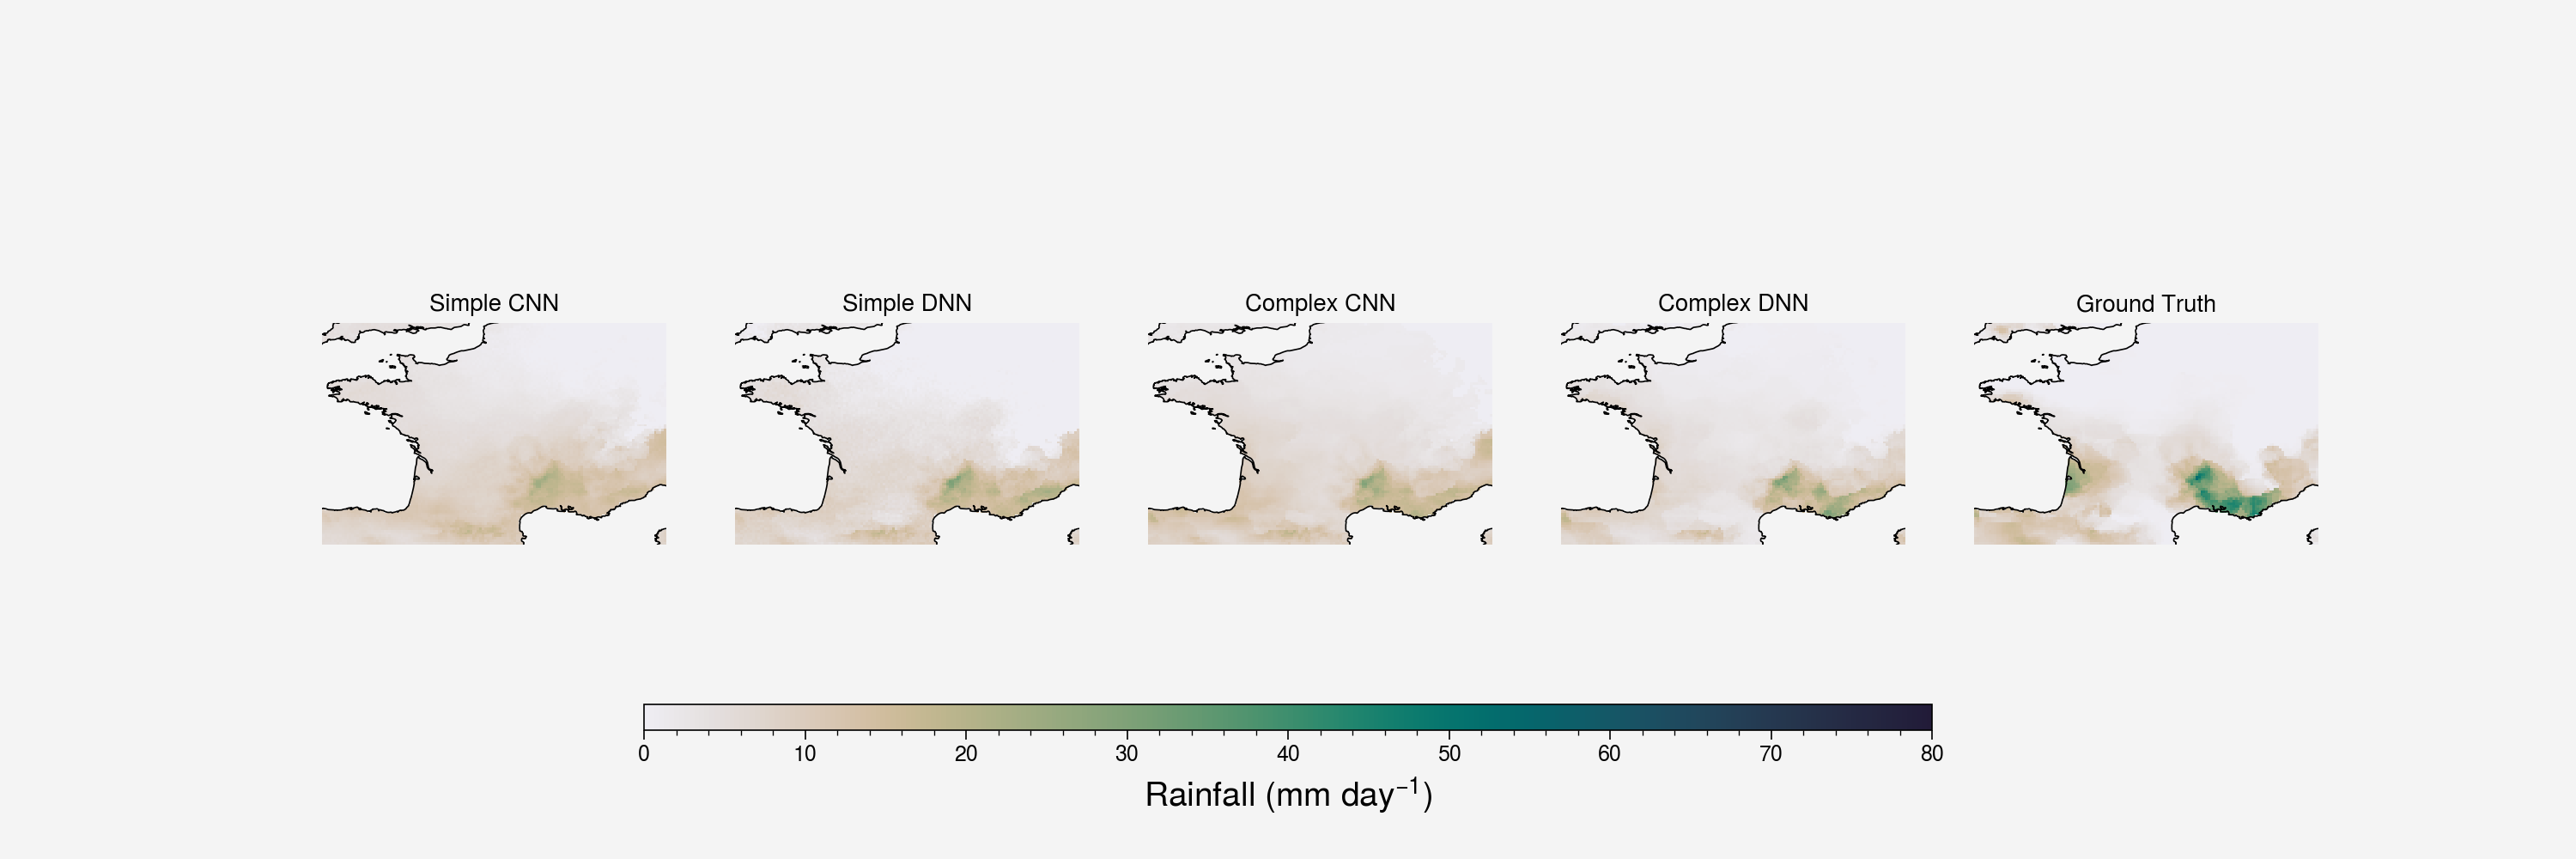

In [60]:
fig, ax = plt.subplots(1,5, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']
for i in range(4):
    concat_predictions_FR.sel(time =date, experiments =exps[i])['test'].plot(vmin =0, vmax =80,
                                                                            cmap ='cmo.rain', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            

cs = gt.sel(time = date).plot(vmin =0, vmax =80, cmap ='cmo.rain', ax = ax[-1],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())          
[axes.set_title('') for axes in ax]
[axes.coastlines() for axes in ax]
ax4 = fig.add_axes([0.25, 0.15, 0.5, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label(r'Rainfall (mm day$^{-1}$)', fontsize =14)
ax[0].set_title('Simple CNN')
ax[1].set_title('Simple DNN')
ax[2].set_title('Complex CNN')
ax[3].set_title('Complex DNN')
ax[4].set_title('Ground Truth')

def remove_spines(ax):
    ax.set_frame_on(False)
    #fig.tight_layout()
[remove_spines(axes) for axes in ax]
plt.show()
#plt.savefig('./Figs/Basic_predict_maps.pdf',format='pdf')

Here, we see that models fail to depict the pretty high intensity event Southeast of France (maybe a cévénol event). Also, complex models do not depict better than simple models the binary component of precipitation, because all of them, expect the Complex DNN maybe (which does it a bis less), indicate slight precipitation where there was not.

## V -  Third Implementation : France (with topography added in input) <a class="anchor" id="5"></a>

Here, we add a supplementary input variable : topography to see if the addition of this input even a low resolution increase the performance of the models. I didn't expect miracles because **machine learning models should not need topography, since it is constant with time and therefore appear in its impact on the atmospheric fields**. Topography should be only useful at a much higher resolution than these atmospheric variables.

My computer wouldn't have been able to handle a higher resolution input.

In [9]:
location = 'FR_topo'

In [10]:
config = dict(y = "./training_data/precip_FR.nc",
              X = "./training_data/ERA5_FR_yes_topo.nc",
             train_start = "2000-01-01",
             train_end = "2007-01-01",
             val_start = "2007-01-02",
             val_end = "2010-01-01",
             test_start = "2010-01-02",
             test_end = "2014-12-01",
             downscale_variables = ['w_850', 'u_850',
             'v_850', 'q_850', 't_850', 'z'])

### Loading Data  <a class="anchor" id="5.1"></a>

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = load_data(config)

[########################################] | 100% Completed | 735.14 ms
[########################################] | 100% Completed | 104.85 ms
[########################################] | 100% Completed | 422.56 ms
[########################################] | 100% Completed | 106.27 ms
[########################################] | 100% Completed | 433.97 ms
[########################################] | 100% Completed | 212.50 ms


### Model training hyperparameters <a class="anchor" id="5.2"></a>
The training hyperparameters are from Rampal et *al.* (2022).

In [12]:
initial_learning_rate =1e-4
dropout = 0.6
input_shape = x_train.shape[1:]
output_shape = y_train.z.size
hidden_layer_dense = 256
batch_size =64
kernel_size = 5
layer_filters =[16, 32, 64]
epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate)

In [13]:
print('Input shape is :', input_shape)
print('Output shape is :',output_shape)

Input shape is : (37, 57, 6)
Output shape is : 9171


### Compilation of the 4 models. <a class="anchor" id="5.3"></a>

In [8]:
#whether to save the models or not, they have been saved already so False
save = True

#### Simple DNN (MSE loss)

In [7]:
simple_dnn_model = simple_dnn(dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape, dropout=dropout)
#keras.utils.plot_model(simple_dnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

2024-01-15 22:33:06.542082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
if save == True : 
    simple_dnn_json = simple_dnn_model.to_json()
    with open("./wgts/simple_dnn_"+location+".json", "w") as json_file:
        json_file.write(simple_dnn_json)

#### Complex DNN ($\Gamma$ loss)

In [8]:
complex_dnn_model = complex_dnn(dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape, dropout=dropout,
                         output_shape=output_shape)
#keras.utils.plot_model(complex_dnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [11]:
if save == True : 
    complex_dnn_json = complex_dnn_model.to_json()
    with open("./wgts/complex_dnn_"+location+".json", "w") as json_file:
        json_file.write(complex_dnn_json)

#### Simple CNN (MSE loss)

In [9]:
simple_cnn_model = simple_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu')
#keras.utils.plot_model(simple_cnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [21]:
if save == True : 
    simple_cnn_json = simple_cnn_model.to_json()
    with open("./wgts/simple_cnn_"+location+".json", "w") as json_file:
        json_file.write(simple_cnn_json)

#### Complex CNN ($\Gamma$ loss)

In [10]:
complex_cnn_model = complex_cnn(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu', output_shape = output_shape)
#keras.utils.plot_model(complex_cnn_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, rankdir="LR")

In [23]:
if save == True : 
    complex_cnn_json = complex_cnn_model.to_json()
    with open("./wgts/complex_cnn_"+location+".json", "w") as json_file:
        json_file.write(complex_cnn_json)

### Model Training <a class="anchor" id="5.4"></a>

In [24]:
save_hist = True

In [25]:
history_cd_FR_topo, complex_dnn_FR_topo = train_model(complex_dnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_dnn_' + location + '.h5',
                             metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cd_FR_topo.history, file)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 37, 57, 6)]  0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 12654)        0           ['input_3[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 12654)        0           ['flatten_2[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 256)          3239680     ['dropout_2[0][0]']              
                                                                                            

In [26]:
history_cc_FR_topo, complex_cnn_FR_topo = train_model(
complex_cnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'complex_cnn_' + location+'.h5',
                            metrics =gamma_mse_metric)
if save_hist == True : 
    with open('./hist/history_cc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_cc_FR_topo.history, file)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 37, 57, 6)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 33, 53, 16)   2416        ['input_5[0][0]']                
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 16, 26, 16)  0           ['conv2d_3[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 26, 16)  64          ['average_pooling2d_3[0][0]

In [27]:
history_sd_FR_topo, simple_dnn_FR_topo = train_model(simple_dnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_dnn_' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sd_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sd_FR_topo.history, file)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 37, 57, 6)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12654)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12654)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3239680   
                                                                 
 dense_3 (Dense)             (None, 9171)              2356947   
                                                                 
Total params: 5,596,627
Trainable params: 5,596,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
40/40 [==============================

In [28]:
history_sc_FR_topo, simple_cnn_FR_topo = train_model(simple_cnn_model, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs = epochs, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'simple_cnn_' + location + '.h5',
                            metrics ='mse')
if save_hist == True : 
    with open('./hist/history_sc_' + location + '.pkl', 'wb') as file:
        pickle.dump(history_sc_FR_topo.history, file)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 37, 57, 6)]       0         
                                                                 
 conv2d (Conv2D)             (None, 33, 53, 16)        2416      
                                                                 
 average_pooling2d (AverageP  (None, 16, 26, 16)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 26, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 22, 32)        12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 11, 32)        0   

### Load models with weights <a class="anchor" id="5.5"></a>

In [14]:
simple_cnn_jsonfile = open('./wgts/simple_cnn_'+location+'.json', 'r')
simple_cnn_test_json = simple_cnn_jsonfile.read()
simple_cnn_jsonfile.close()
simple_cnn = model_from_json(simple_cnn_test_json)
# load weights into new model
simple_cnn.load_weights('./wgts/simple_cnn_' + location + '.h5')
print("Loaded model from disk")


complex_cnn_jsonfile = open('./wgts/complex_cnn_'+location+'.json', 'r')
complex_cnn_test_json = complex_cnn_jsonfile.read()
complex_cnn_jsonfile.close()
complex_cnn = model_from_json(complex_cnn_test_json)
# load weights into new model
complex_cnn.load_weights('./wgts/complex_cnn_' + location + '.h5')
print("Loaded model from disk")
#DNN

simple_dnn_jsonfile = open('./wgts/simple_dnn_'+location+'.json', 'r')
simple_dnn_test_json = simple_dnn_jsonfile.read()
simple_dnn_jsonfile.close()
simple_dnn = model_from_json(simple_dnn_test_json)
# load weights into new model
simple_dnn.load_weights('./wgts/simple_dnn_' + location + '.h5')
print("Loaded model from disk")


complex_dnn_jsonfile = open('./wgts/complex_dnn_'+location+'.json', 'r')
complex_dnn_test_json = complex_dnn_jsonfile.read()
complex_dnn_jsonfile.close()
complex_dnn = model_from_json(complex_dnn_test_json)
# load weights into new model
complex_dnn.load_weights('./wgts/complex_dnn_' + location + '.h5')
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


### Inference <a class="anchor" id="5.6"></a>

In [15]:
simple_cnn_prediction = infer(simple_cnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
simple_dnn_prediction = infer(simple_dnn, x_test, y_test, 32, 'pr', "test", 'mse', 0.5)
complex_cnn_prediction = infer(complex_cnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)
complex_dnn_prediction = infer(complex_dnn, x_test, y_test, 32, 'pr', "test", 'gamma', 0.5)

concat_predictions_FR_topo = xr.concat([simple_cnn_prediction, simple_dnn_prediction,complex_cnn_prediction, complex_dnn_prediction], dim ="experiments")
concat_predictions_FR_topo['experiments'] = (('experiments'),['simple_cnn','simple_dnn', 'complex_cnn', 'complex_dnn'])

gt = y_test.unstack()
gt = gt.reindex(lon = sorted(gt.lon.values))

50/50 [==============================] - 0s 7ms/step


### Performance analysis <a class="anchor" id="5.7"></a>

#### Loss and MSE during training

In this part, I load the history, so I don't have to re-train the models (which is very long), so they must have been saved beforehand.

In [9]:
with open('./hist/history_sd_' + location + '.pkl', 'rb') as file:
    history_sd_FR_topo = pickle.load(file)
    
with open('./hist/history_sc_' + location + '.pkl', 'rb') as file:
    history_sc_FR_topo = pickle.load(file)
    
with open('./hist/history_cc_' + location + '.pkl', 'rb') as file:
    history_cc_FR_topo = pickle.load(file)
    
with open('./hist/history_cd_' + location + '.pkl', 'rb') as file:
    history_cd_FR_topo = pickle.load(file)

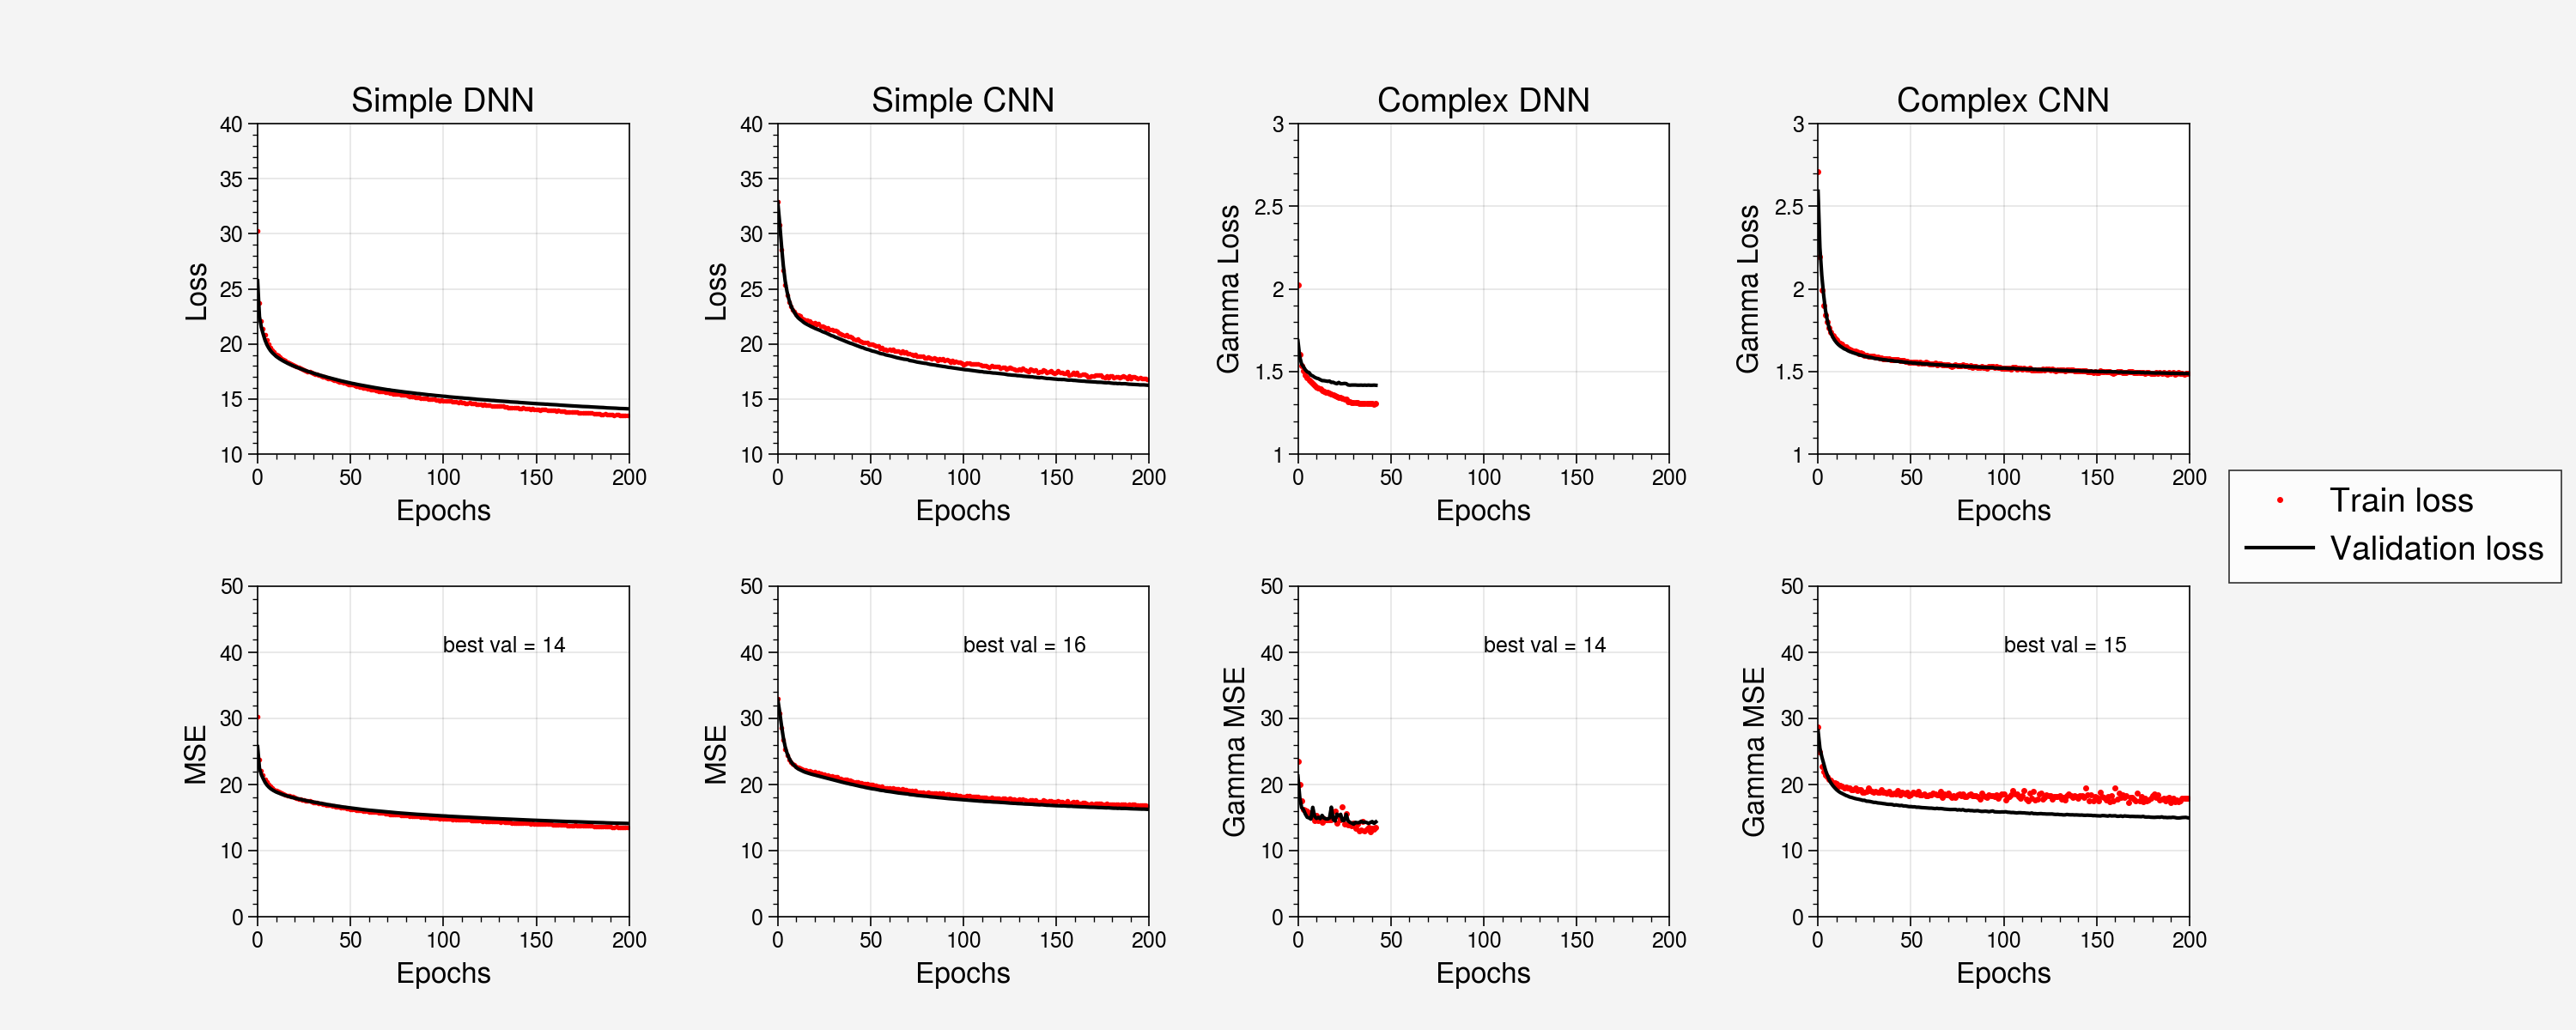

In [10]:
plt.close('all')
fig=plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 4, 1)
ax1.plot(history_sd_FR_topo['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_FR_topo['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(10,40)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple DNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 2)
ax1.plot(history_sc_FR_topo['loss'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_FR_topo['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(10,40)
ax1.set_ylabel('Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Simple CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 3)
ax1.plot(history_cd_FR_topo['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_FR_topo['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(1,3)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex DNN', fontsize=14)



ax1 = fig.add_subplot(2, 4, 4)
ax1.plot(history_cc_FR_topo['loss'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_FR_topo['val_loss'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(1,3)
ax1.set_ylabel('Gamma Loss',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)
ax1.set_title('Complex CNN', fontsize=14)

ax1 = fig.add_subplot(2, 4, 5)
ax1.plot(history_sd_FR_topo['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sd_FR_topo['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_sd_FR_topo['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 6)
ax1.plot(history_sc_FR_topo['mse'],'ko', color='red',label='Train loss', markersize=1.)
ax1.plot(history_sc_FR_topo['val_mse'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_sc_FR_topo['val_mse'][-1]))
ax1.set_ylabel('MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)


ax1 = fig.add_subplot(2, 4, 7)
ax1.plot(history_cd_FR_topo['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cd_FR_topo['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.text(100, 40,'best val = {:.0f}'.format(history_cd_FR_topo['val_gamma_mse_metric'][-1]))
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

ax1 = fig.add_subplot(2, 4, 8)
ax1.plot(history_cc_FR_topo['gamma_mse_metric'],'ko',color='red',label='Train loss', markersize=1.5)
ax1.plot(history_cc_FR_topo['val_gamma_mse_metric'], 'k',label='Validation loss')
ax1.text(100, 40,'best val = {:.0f}'.format(history_cc_FR_topo['val_gamma_mse_metric'][-1]))
ax1.set_xlim(0,200)
ax1.set_ylim(0,50)
ax1.set_ylabel('Gamma MSE',fontsize=12)
ax1.set_xlabel('Epochs',fontsize=12)

plt.subplots_adjust(left = 0.1, right=0.85,hspace=0.4, wspace=0.4)
plt.legend(bbox_to_anchor = (2, 1.35),ncol = 1, fontsize=14)
plt.show()
#plt.savefig('./Figs/histories_'+location+'.pdf',format='pdf')


As for France without topography, the best performing models seem to be the two DNN ones. Actually the performance of the models seem to be similar whether we add topography as input or not.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the space dimension)

In [11]:
a = np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='complex_cnn'), dim=['lat', 'lon']))**2
b = np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='complex_dnn'), dim=['lat', 'lon']))**2
r_squared = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='simple_cnn'), dim=['lat', 'lon']))**2,
    'Simple DNN': np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='simple_dnn'), dim=['lat', 'lon']))**2,
    'Complex DNN': b[~np.isnan(b)]
}
del(a,b)

rmse = {
    'Complex CNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='complex_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple CNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='simple_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple DNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='simple_dnn')).mean(dim=['lat', 'lon']))**2),
    'Complex DNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='complex_dnn')).mean(dim=['lat', 'lon']))**2)
}


percentile_90 = gt.quantile(0.9)

#select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

a=np.reshape(np.array((-gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='complex_cnn'))/gt_exceeding_90th)*100,-1)
b=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='simple_cnn'))/gt_exceeding_90th)*100,-1)
c=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='simple_dnn'))/gt_exceeding_90th)*100,-1)
d=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='complex_dnn'))/gt_exceeding_90th)*100,-1)

percentthp = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': b[~np.isnan(b)],
    'Simple DNN': c[~np.isnan(c)],
    'Complex DNN': d[~np.isnan(d)]
}

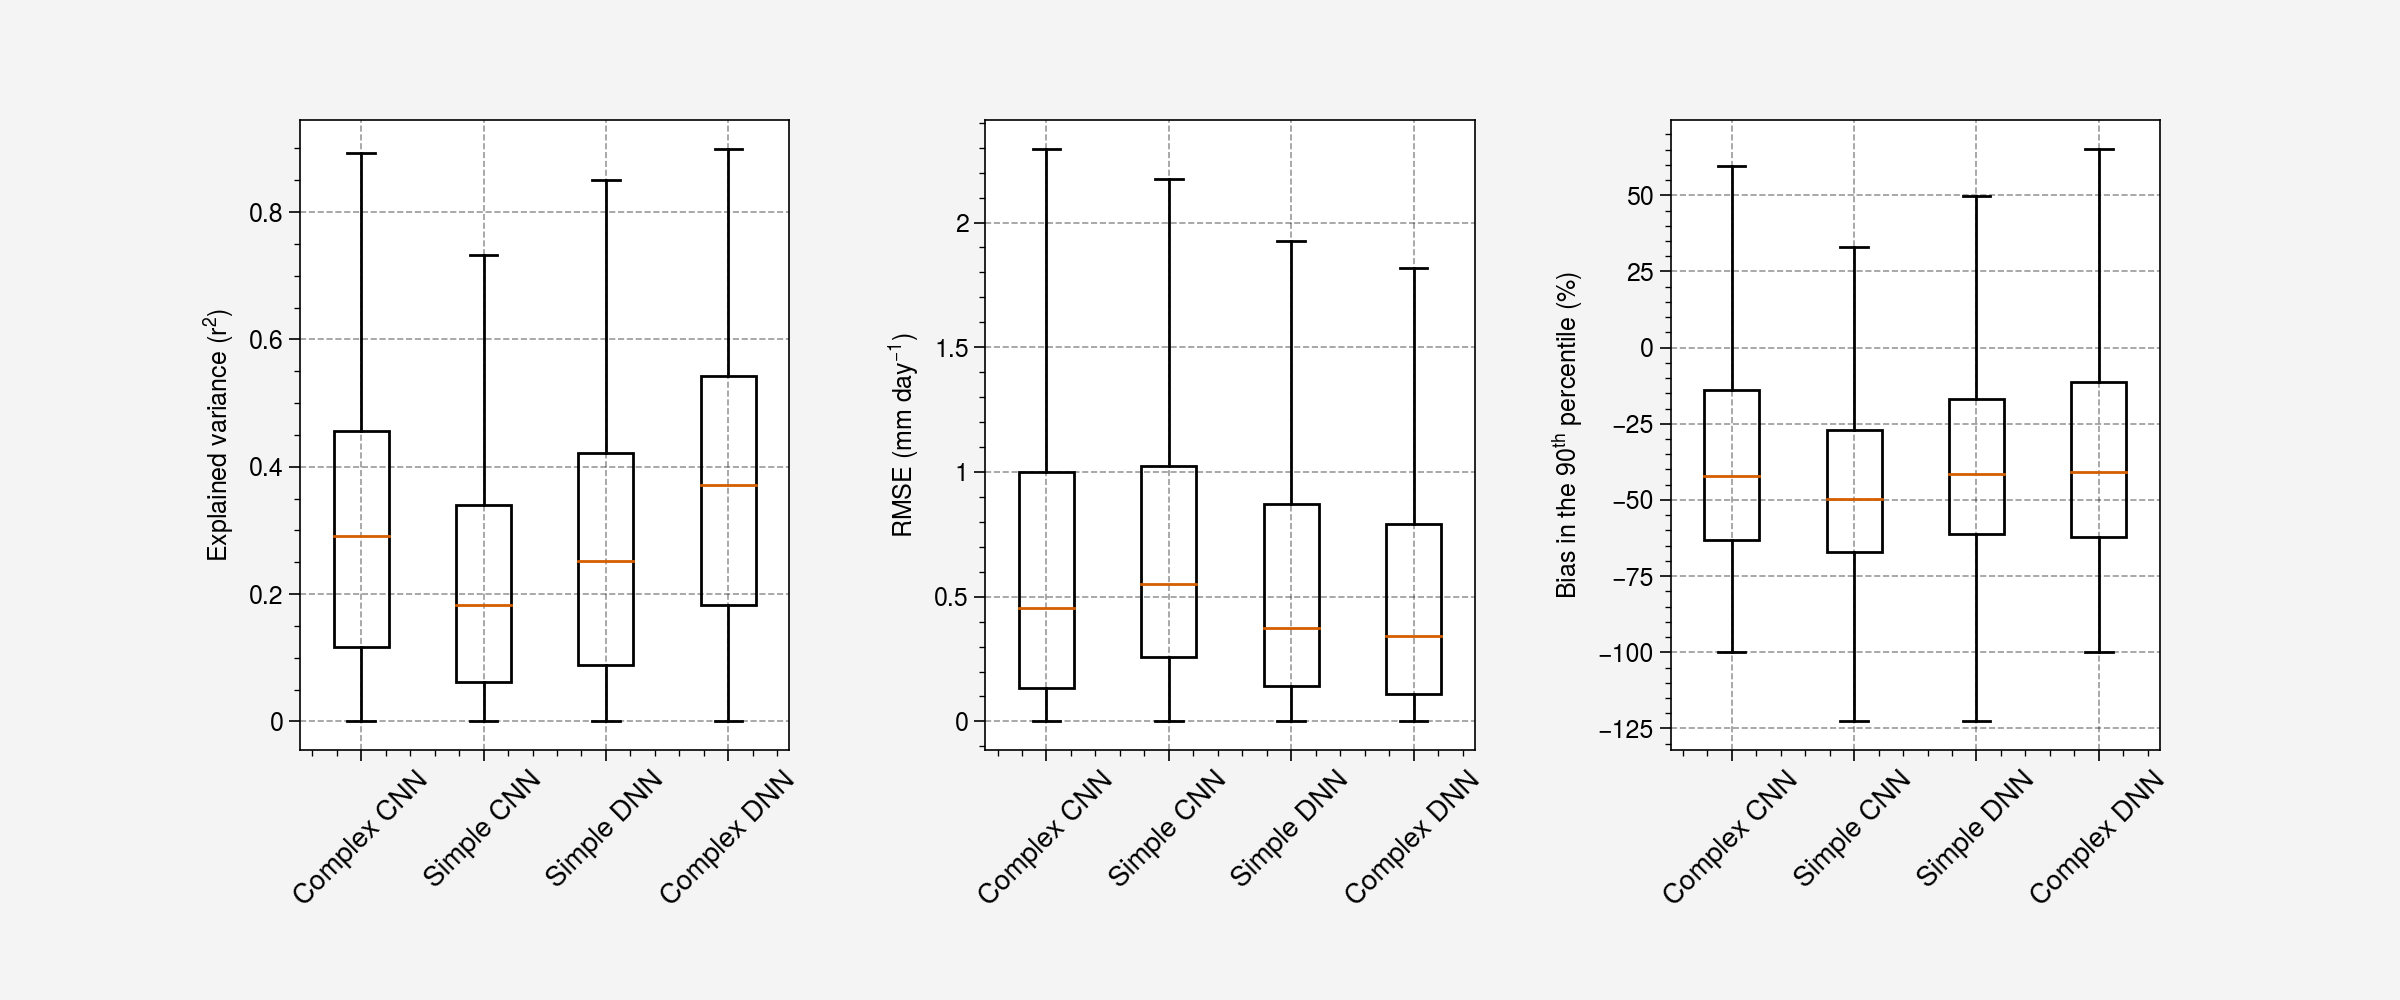

In [12]:
plt.close('all')
fig=plt.figure(1, figsize=(12,5))

ax = fig.add_subplot(1, 3, 1)
ax.boxplot(r_squared.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(r_squared.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Explained variance ($r^2$)')

ax = fig.add_subplot(1, 3, 2)
ax.boxplot(rmse.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(rmse.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'RMSE (mm day$^{-1}$)')

ax = fig.add_subplot(1, 3, 3)
ax.boxplot(percentthp.values(), showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticklabels(percentthp.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Bias in the $90^{th}$ percentile (%)')
plt.subplots_adjust(bottom=0.25, wspace=0.4)
plt.show()

**These results look the same as France without topography.**

Here we see that the overall best model is the Complex DNN, because it has the greatest explained variance ($r^2$), the smallest RMSE (root mean square error) and the smallest absolute bias in the 90$^{th}$ percentile.
I would guess that the reason the Complex CNN one is not the best for France, is because of its complex topography and it complex localisation, on the path of westerlies coming from the Atlantic, but also surrounded by land on the Southwest, Southeast and mostly East, contrary to New Zealand which has also a complex topography, but is an island in the middle of the ocean.

#### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the time dimension)

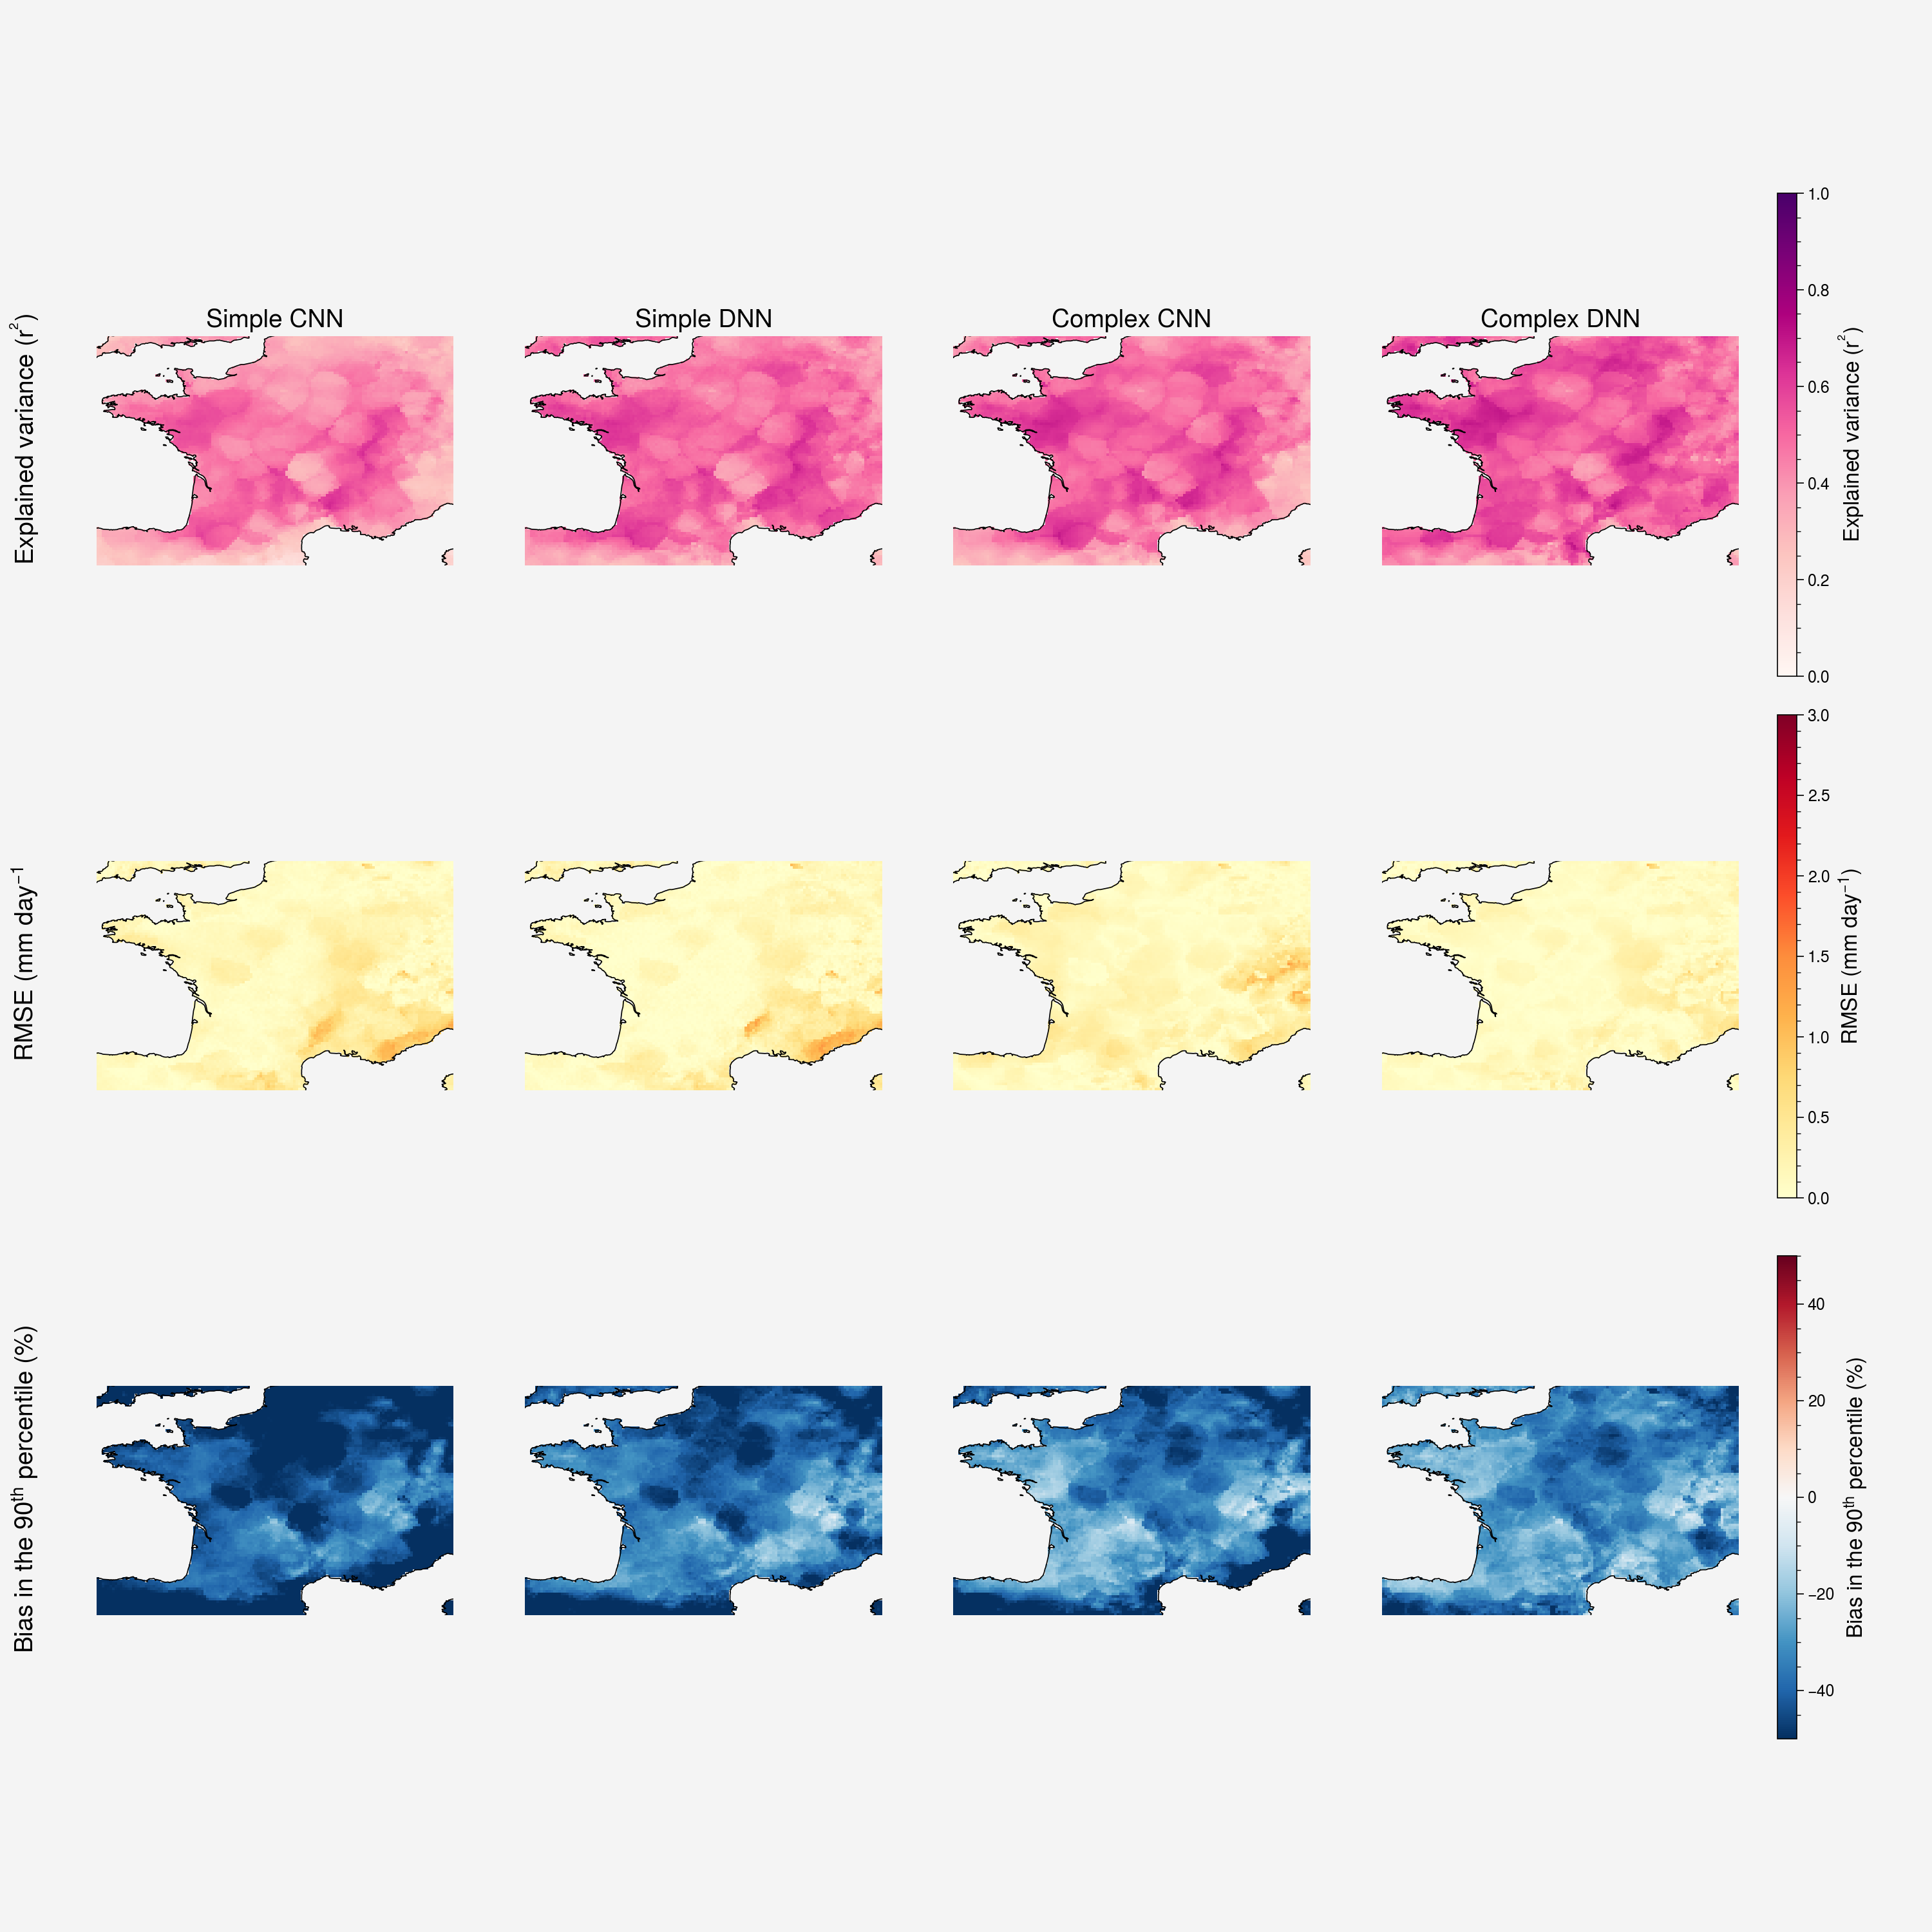

In [13]:
plt.close('all')
fig, ax = plt.subplots(3,4, figsize = (15, 15), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']

percentile_90 = gt.quantile(0.9)

# Step 2: Select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

for i in range(4):
    
    cs1 = (xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments=exps[i]), dim=['time'])**2).plot(vmin =0, vmax =1,
                                                                            cmap ='RdPu', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            


    cs2 = np.sqrt((gt - concat_predictions_FR_topo.test.sel(experiments=exps[i])).mean(dim=['time'])**2).plot(vmin =0, vmax =3,
                                                                            cmap ='YlOrRd', ax = ax[i+4],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 
    
    
    
    cs3 = (((-gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments=exps[i]))/gt_exceeding_90th)*100).mean(dim='time').plot(vmin =-50, vmax =50,
                                                                            cmap ='RdBu_r', ax = ax[i+8],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree()) 


    ax[i+4].set_title('')
    ax[i+8].set_title('')
ax[0].text(-0.2, 0.55, r'Explained variance ($r^{^2}$)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[0].transAxes, fontsize=14)

ax[4].text(-0.2, 0.55, r'RMSE (mm day$^{-1}$', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[4].transAxes, fontsize=14)
   
ax[8].text(-0.2, 0.55, r'Bias in the $90^{th}$ percentile (%)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[8].transAxes, fontsize=14)
     

[axes.coastlines() for axes in ax]

ax[0].set_title('Simple CNN', fontsize=14)
ax[1].set_title('Simple DNN', fontsize=14)
ax[2].set_title('Complex CNN', fontsize=14)
ax[3].set_title('Complex DNN', fontsize=14)

[remove_spines(axes) for axes in ax]

cbar1 = fig.colorbar(cs1, cax=fig.add_axes([0.92, 0.65, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar1.set_label(r'Explained variance ($r^{^2}$)', fontsize =12)
cbar2 = fig.colorbar(cs2, cax=fig.add_axes([0.92, 0.38, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar2.set_label(r'RMSE (mm day$^{-1}$)', fontsize =12)
cbar3 = fig.colorbar(cs3, cax=fig.add_axes([0.92, 0.10, 0.010, 0.25]), orientation ='vertical')#left, bottom, width, height
cbar3.set_label(r'Bias in the $90^{th}$ percentile (%)', fontsize =12)

plt.subplots_adjust(left=0.05)
#plt.savefig('./Figs/Maps_'+location+'_bias_rms_r_sqrd.pdf',format='pdf')

**These results look the same as France without topography.**

Here also, we see that the Complex DNN model is the best overall. But what I notice the most is the patchy pattern on the whole country, for all models, there seems to be not spatial understanding of the models, indicating a lack in the knowledge of the topography.
Also, the bias in the 90$^{th}$ percentile is huge (around 50% lower) : there is a flaw in predicting high intensity precipitation, same as for New Zealand.

#### Prediction example 

In [14]:
date = "2010-11-20"

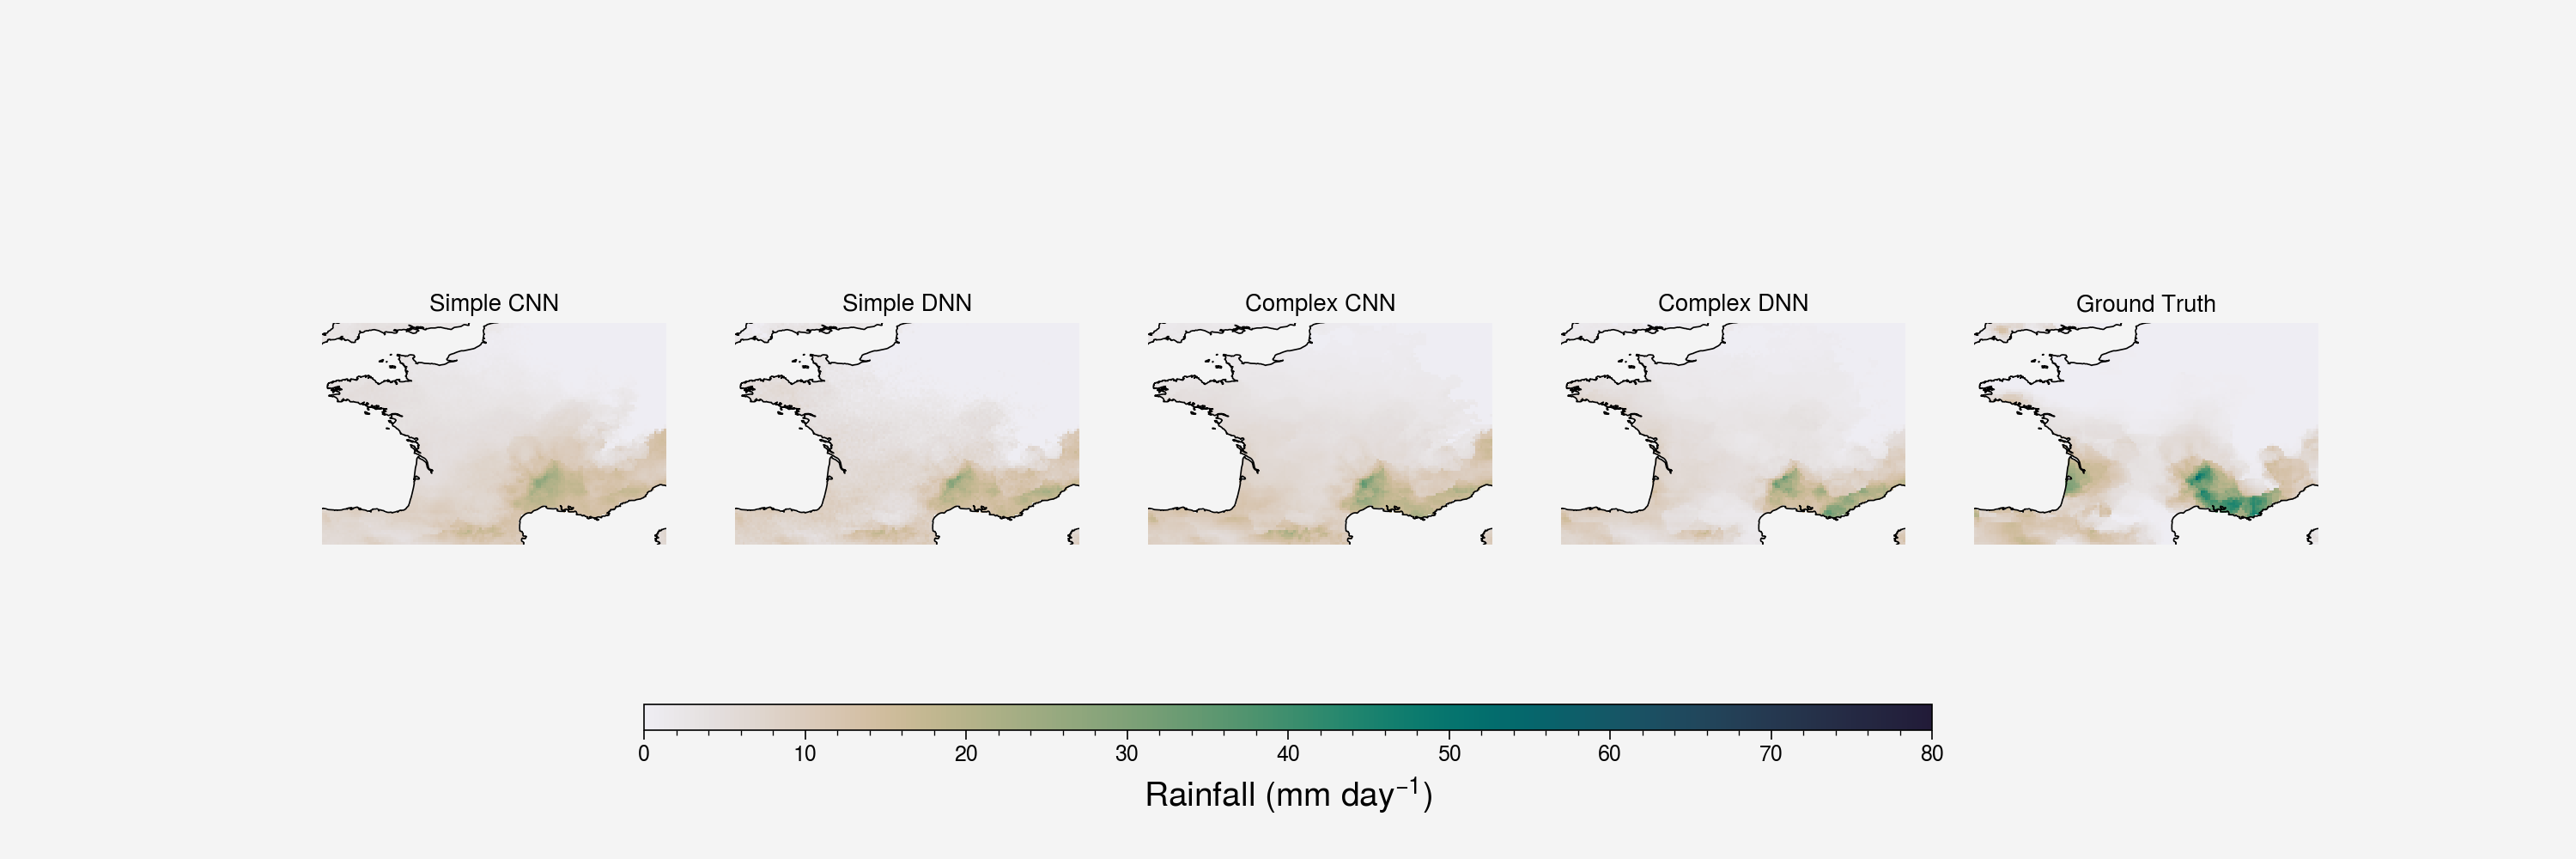

In [54]:
fig, ax = plt.subplots(1,5, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']
for i in range(4):
    concat_predictions_FR_topo.sel(time =date, experiments =exps[i])['test'].plot(vmin =0, vmax =80,
                                                                            cmap ='cmo.rain', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            

cs = gt.sel(time = date).plot(vmin =0, vmax =80, cmap ='cmo.rain', ax = ax[-1],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())          
[axes.set_title('') for axes in ax]
[axes.coastlines() for axes in ax]
ax4 = fig.add_axes([0.25, 0.15, 0.5, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label(r'Rainfall (mm day$^{-1}$)', fontsize =14)
ax[0].set_title('Simple CNN')
ax[1].set_title('Simple DNN')
ax[2].set_title('Complex CNN')
ax[3].set_title('Complex DNN')
ax[4].set_title('Ground Truth')

def remove_spines(ax):
    ax.set_frame_on(False)
    #fig.tight_layout()
[remove_spines(axes) for axes in ax]
plt.show()
#plt.savefig('./Figs/Basic_predict_maps.pdf',format='pdf')

**These results look the same as France without topography.**

Here, we see that models fail to depict the pretty high intensity event Southeast of France (maybe a cévénol event). Also, complex models do not depict better than simple models the binary component of precipitation, because all of them, expect the Complex DNN maybe (which does it a bis less), indicate slight precipitation where there was not.

## VI - Effect of topography as additional input (France) <a class="anchor" id="6"></a>

Here, I want to compare the difference in performance and biases of the models caused by the addition or not of the topography in input variables.

### Prediction difference <a class="anchor" id="6.1"></a>

In [16]:
date = "2010-11-20"

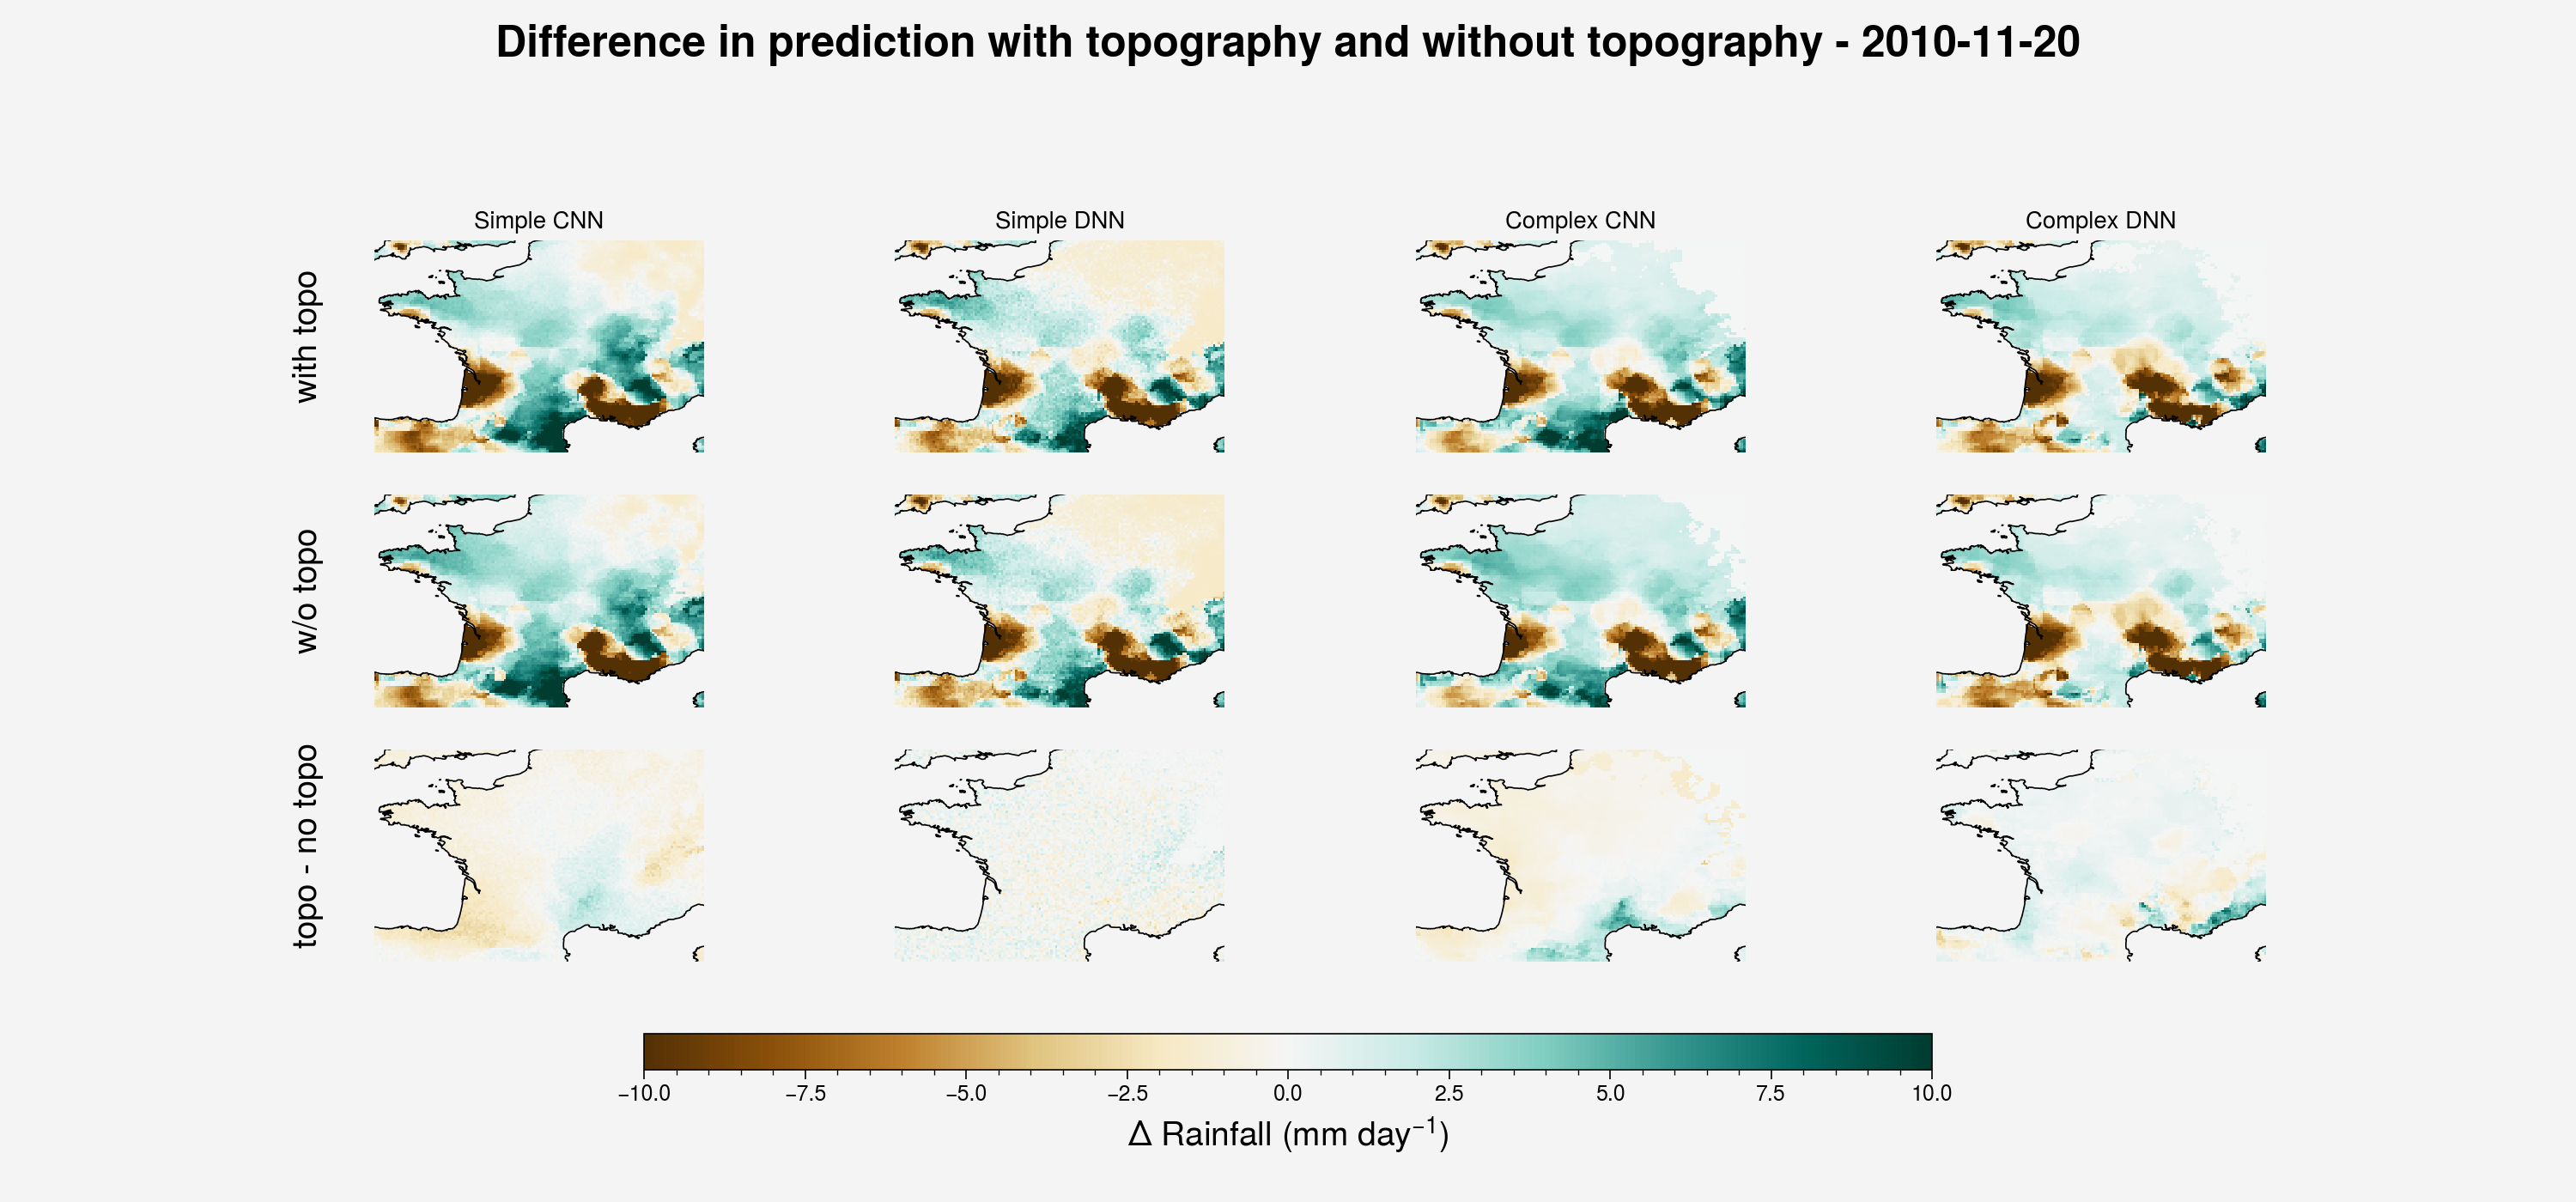

In [53]:
fig, ax = plt.subplots(3,4, figsize = (15, 7), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']

for i in range(4):
    diff_topo = concat_predictions_FR_topo.sel(time =date, experiments =exps[i])['test'] - gt.sel(time = date)
    diff_no_topo = concat_predictions_FR.sel(time =date, experiments =exps[i])['test'] - gt.sel(time = date)
    cs=diff_topo.plot(vmin =-10, vmax =10,cmap ='BrBG', ax = ax[i],add_colorbar =False,transform = ccrs.PlateCarree()) 
    diff_no_topo.plot(vmin =-10, vmax =10,cmap ='BrBG', ax = ax[i+4],add_colorbar =False,transform = ccrs.PlateCarree()) 
    (diff_topo - diff_no_topo).plot(vmin =-10, vmax =10,cmap ='BrBG', ax = ax[i+8],add_colorbar =False,transform = ccrs.PlateCarree()) 

ax[0].text(-0.2, 0.55, r'with topo', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[0].transAxes, fontsize=14)

ax[4].text(-0.2, 0.55, r'w/o topo', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[4].transAxes, fontsize=14)
   
ax[8].text(-0.2, 0.55, r'topo - no topo', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[8].transAxes, fontsize=14)
  
    
[axes.set_title('') for axes in ax]
[axes.coastlines() for axes in ax]
ax4 = fig.add_axes([0.25, 0.11, 0.5, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label(r'$\Delta$ Rainfall (mm day$^{-1}$)', fontsize =14)
ax[0].set_title('Simple CNN')
ax[1].set_title('Simple DNN')
ax[2].set_title('Complex CNN')
ax[3].set_title('Complex DNN')


[remove_spines(axes) for axes in ax]
plt.suptitle('Difference in prediction with topography and without topography - '+date, fontsize = 18)
plt.subplots_adjust(bottom = 0.2, top=0.8)
plt.show()

Overall, we can see here that the addition of topography allows the models to move a little more in the right direction. The Southeast of France get a bit wetter while the rest gets a bit drier. Though, the Simple DNN model is lost doesn't really take into consideration the added input, as the resulting difference is only noise, with a lack of spatial patterns. 
On the other hand, if we look more in detail, the Complex models with topography are adding more rain in places there was not, and less rain where it was really intense.

Therefore, the addition of topography seems to be pretty useless, form this isolated day.

### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the space dimension) <a class="anchor" id="6.2"></a>

Now, let's look at the statistics (because obviously we do science, so we won't conclude anything from a sample of 1).

In [17]:
a = np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='complex_cnn'), dim=['lat', 'lon']))**2
b = np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='complex_dnn'), dim=['lat', 'lon']))**2
r_squared_2 = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='simple_cnn'), dim=['lat', 'lon']))**2,
    'Simple DNN': np.array(xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments='simple_dnn'), dim=['lat', 'lon']))**2,
    'Complex DNN': b[~np.isnan(b)]
}
del(a,b)

rmse_2 = {
    'Complex CNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='complex_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple CNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='simple_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple DNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='simple_dnn')).mean(dim=['lat', 'lon']))**2),
    'Complex DNN': np.sqrt(np.array((gt - concat_predictions_FR_topo.test.sel(experiments='complex_dnn')).mean(dim=['lat', 'lon']))**2)
}


percentile_90 = gt.quantile(0.9)

#select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

a=np.reshape(np.array((-gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='complex_cnn'))/gt_exceeding_90th)*100,-1)
b=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='simple_cnn'))/gt_exceeding_90th)*100,-1)
c=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='simple_dnn'))/gt_exceeding_90th)*100,-1)
d=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments='complex_dnn'))/gt_exceeding_90th)*100,-1)

percentthp_2 = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': b[~np.isnan(b)],
    'Simple DNN': c[~np.isnan(c)],
    'Complex DNN': d[~np.isnan(d)]
}

a = np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='complex_cnn'), dim=['lat', 'lon']))**2
b = np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='complex_dnn'), dim=['lat', 'lon']))**2
r_squared = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='simple_cnn'), dim=['lat', 'lon']))**2,
    'Simple DNN': np.array(xr.corr(gt, concat_predictions_FR.test.sel(experiments='simple_dnn'), dim=['lat', 'lon']))**2,
    'Complex DNN': b[~np.isnan(b)]
}
del(a,b)

rmse = {
    'Complex CNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='complex_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple CNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='simple_cnn')).mean(dim=['lat', 'lon']))**2),
    'Simple DNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='simple_dnn')).mean(dim=['lat', 'lon']))**2),
    'Complex DNN': np.sqrt(np.array((gt - concat_predictions_FR.test.sel(experiments='complex_dnn')).mean(dim=['lat', 'lon']))**2)
}


percentile_90 = gt.quantile(0.9)

#select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

a=np.reshape(np.array((-gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='complex_cnn'))/gt_exceeding_90th)*100,-1)
b=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='simple_cnn'))/gt_exceeding_90th)*100,-1)
c=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='simple_dnn'))/gt_exceeding_90th)*100,-1)
d=np.reshape(np.array((- gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments='complex_dnn'))/gt_exceeding_90th)*100,-1)

percentthp = {
    'Complex CNN': a[~np.isnan(a)],
    'Simple CNN': b[~np.isnan(b)],
    'Simple DNN': c[~np.isnan(c)],
    'Complex DNN': d[~np.isnan(d)]
}

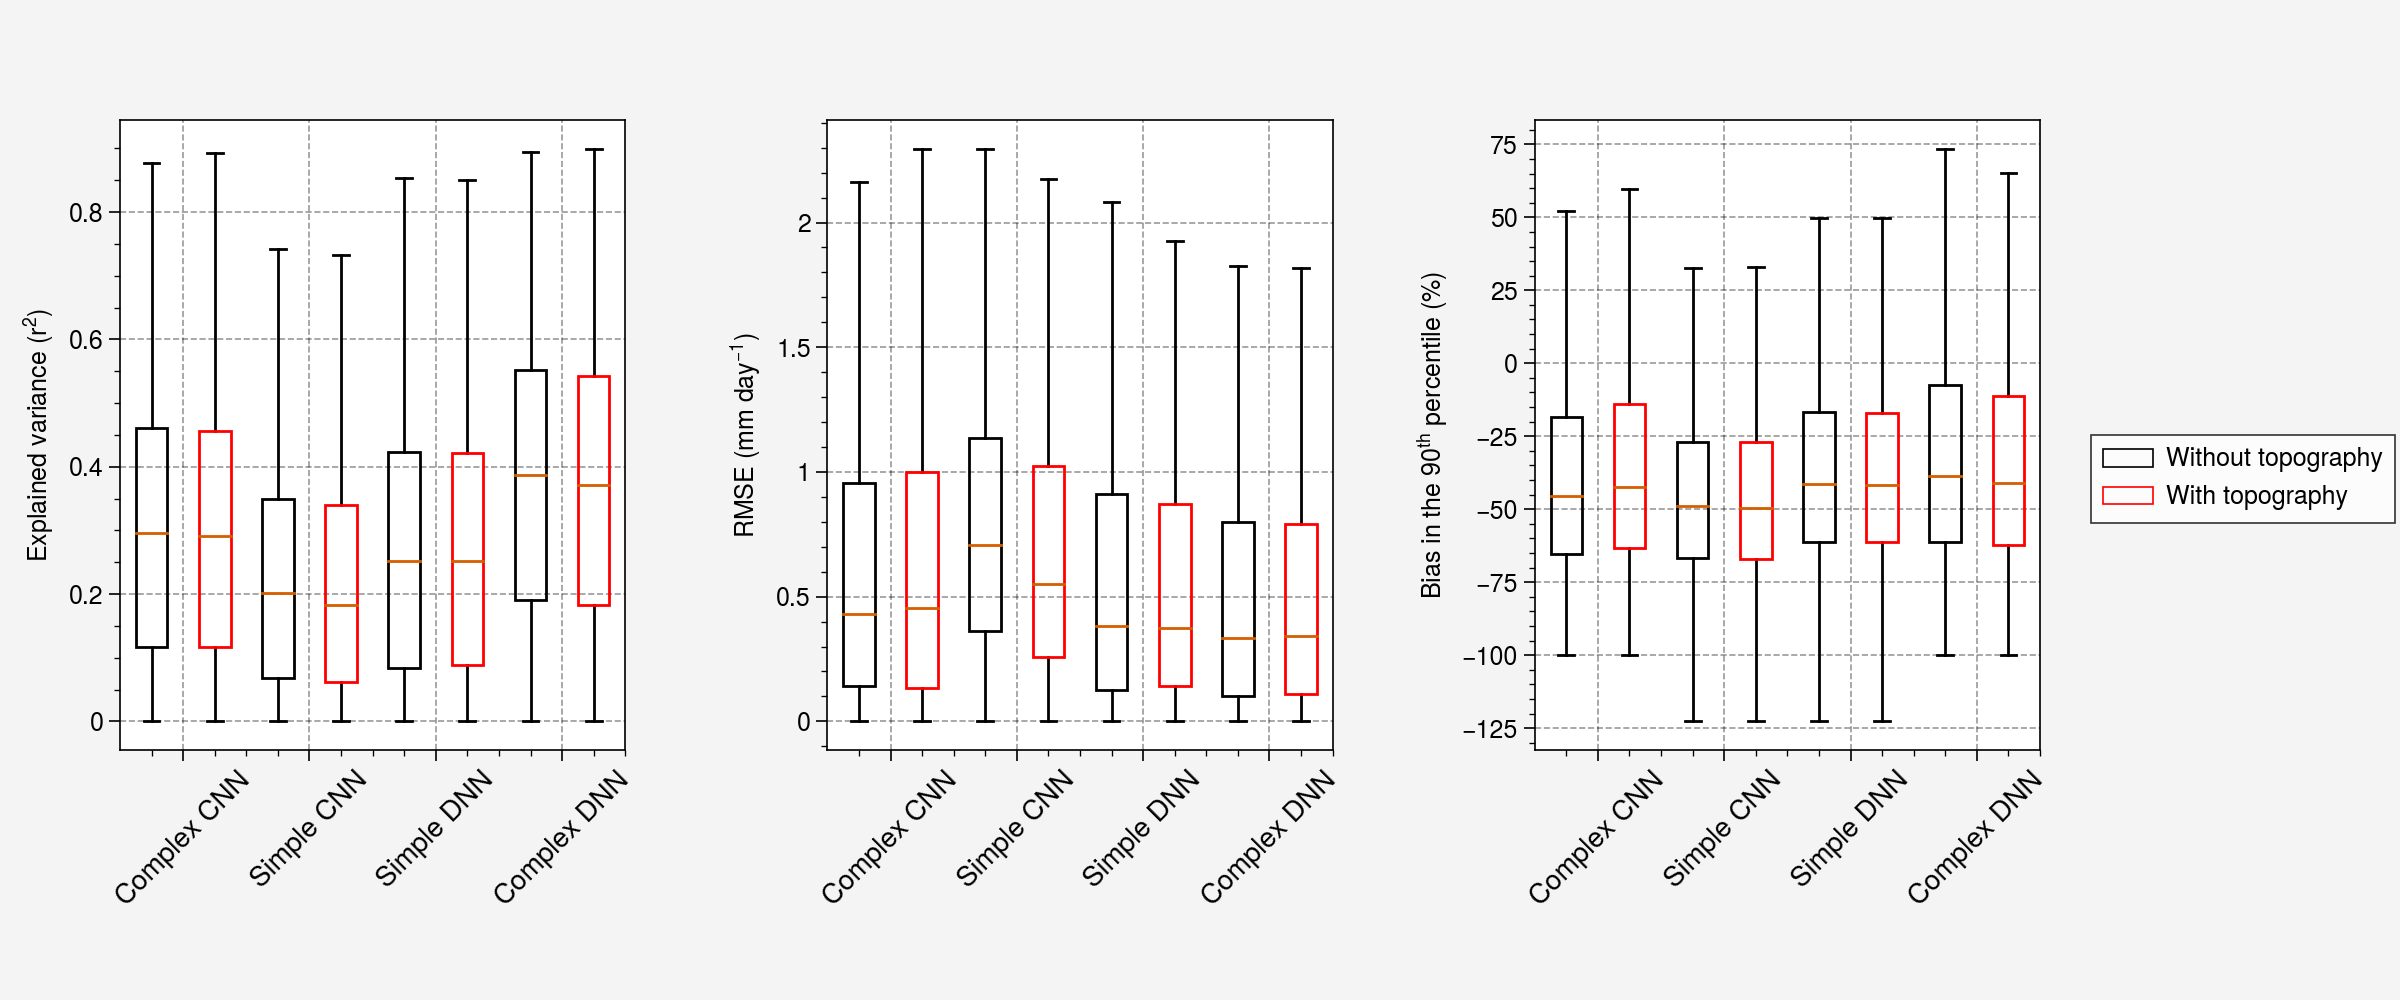

In [31]:
from matplotlib.patches import Patch
plt.close('all')
fig=plt.figure(1, figsize=(12,5))

common_keys = set(r_squared.keys()).intersection(r_squared_2.keys())
positions = range(1, len(common_keys) * 2 + 1, 2)

# Extract data for boxplots
data1 = [r_squared[key] for key in common_keys]
data2 = [r_squared_2[key] for key in common_keys]

ax = fig.add_subplot(1, 3, 1)
ax.boxplot(data1, positions=positions, showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.boxplot(data2, positions=[pos + 1 for pos in positions], showfliers=False, patch_artist=True, boxprops = {'edgecolor':'red','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticks([pos + 0.5 for pos in positions])
ax.set_xticklabels(r_squared.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Explained variance ($r^2$)')

del(data1,data2)
data1 = [rmse[key] for key in common_keys]
data2 = [rmse_2[key] for key in common_keys]

ax = fig.add_subplot(1, 3, 2)
ax.boxplot(data1, positions=positions, showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.boxplot(data2, positions=[pos + 1 for pos in positions], showfliers=False, patch_artist=True, boxprops = {'edgecolor':'red','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticks([pos + 0.5 for pos in positions])
ax.set_xticklabels(rmse.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'RMSE (mm day$^{-1}$)')

del(data1,data2)
data1 = [percentthp[key] for key in common_keys]
data2 = [percentthp_2[key] for key in common_keys]

ax = fig.add_subplot(1, 3, 3)
ax.boxplot(data1, positions=positions, showfliers=False, patch_artist=True, boxprops = {'edgecolor':'black','facecolor': 'None'})
ax.boxplot(data2, positions=[pos + 1 for pos in positions], showfliers=False, patch_artist=True, boxprops = {'edgecolor':'red','facecolor': 'None'})
ax.grid(alpha=0.4, linestyle='dashed')
ax.set_xticks([pos + 0.5 for pos in positions])
ax.set_xticklabels(percentthp.keys(), fontsize=10,rotation=45)
ax.set_ylabel(r'Bias in the $90^{th}$ percentile (%)')


legend_elements = [Patch(facecolor='None', edgecolor='black', label='Without topography'),
                   Patch(facecolor='None', edgecolor='red', label='With topography')]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.1,0.5))


plt.subplots_adjust(left=0.05, right=0.85, bottom=0.25, wspace=0.4)
plt.show()

Here we see that, overall, with topography, the explained variance is worse, while the RMSE is slighly improved for Simple CNN, but remains the same for the rest. The bias in the 90$^{th}$ percentile also remains the same, apart from the Complex CNN, for which it has improved slightly.

**Therefore, we can conclude indeed that the addition of topography did not improve the performance of the models, but it is good to know for sure that low resolution topography cannot change our predictions for the better.**

### Explained variance ($r^2$), RMSE and bias in the 90th percentile (on the time dimension) <a class="anchor" id="6.3"></a>

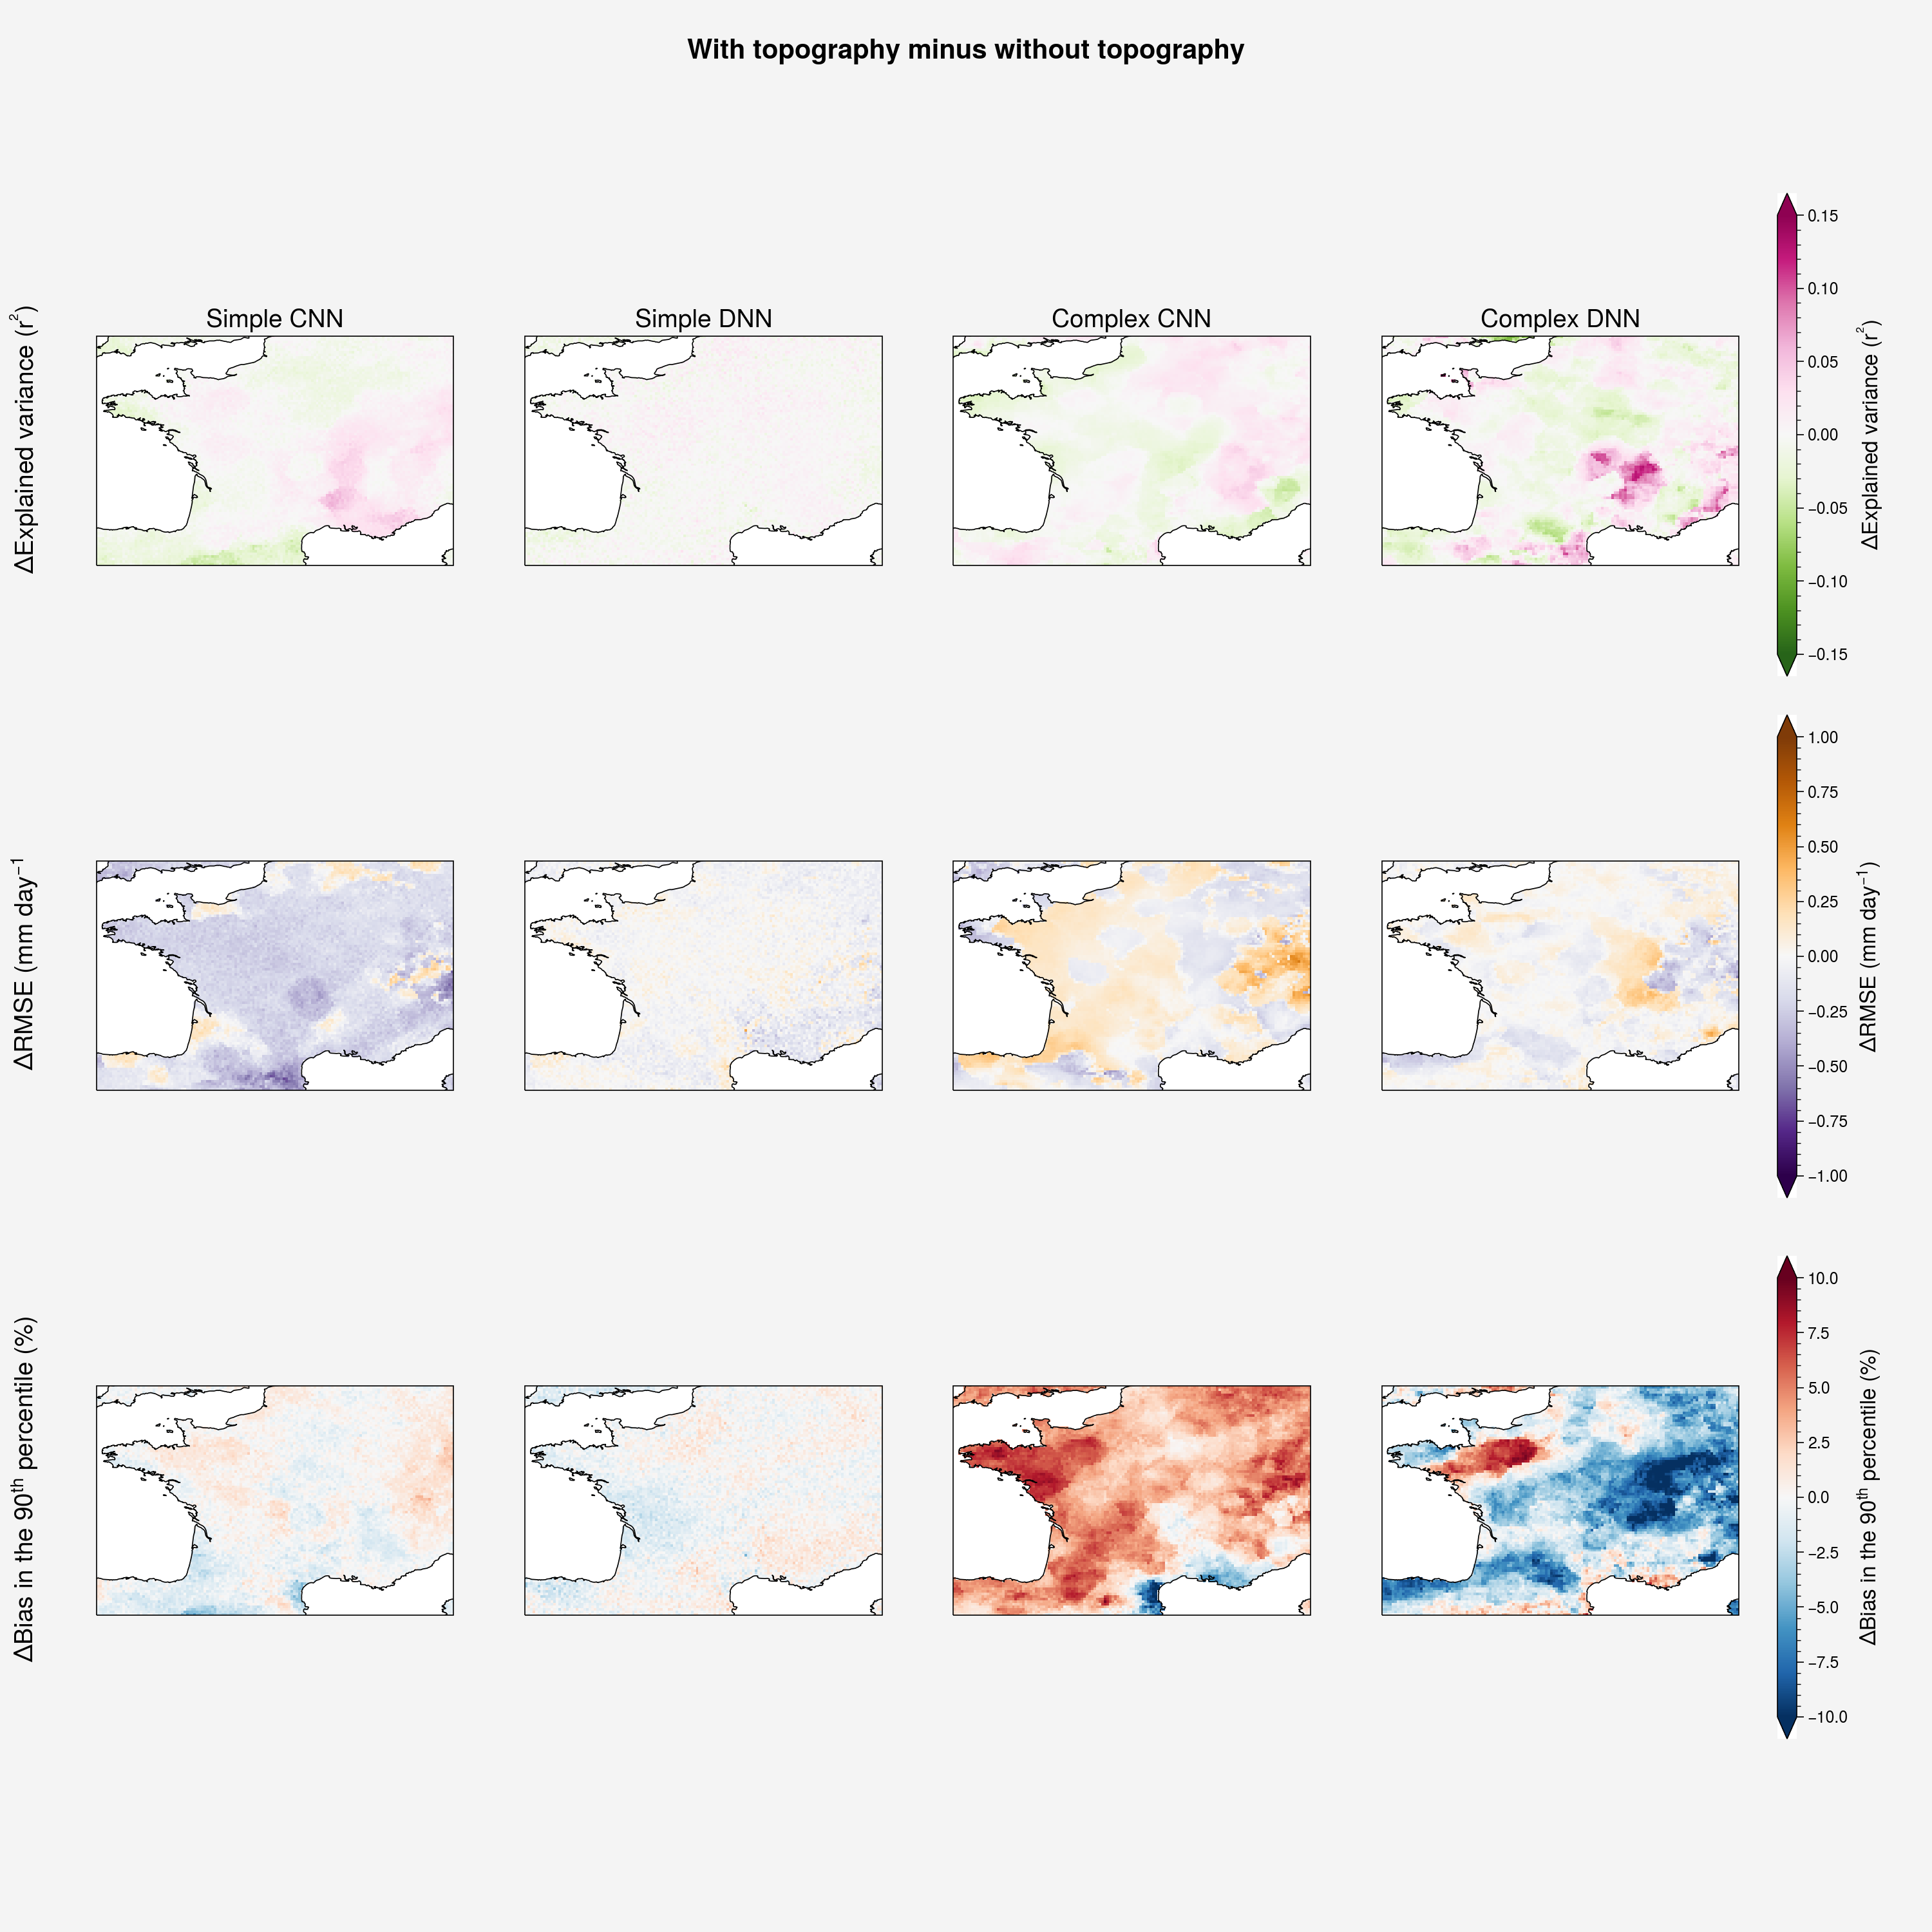

In [56]:
plt.close('all')
fig, ax = plt.subplots(3,4, figsize = (15, 15), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
exps_title = ['Simple CNN','Simple DNN', 'Complex CNN', 'Complex DNN']
exps=['simple_cnn','simple_dnn','complex_cnn', 'complex_dnn']

percentile_90 = gt.quantile(0.9)

# Step 2: Select days and points in gt exceeding the 90th percentile
gt_exceeding_90th = gt.where(gt > percentile_90, drop=True)

for i in range(4):
    diff1 = xr.corr(gt, concat_predictions_FR_topo.test.sel(experiments=exps[i]), dim=['time'])**2 - xr.corr(gt, concat_predictions_FR.test.sel(experiments=exps[i]), dim=['time'])**2
    cs1 = diff1.plot(vmin =-0.15, vmax =0.15,cmap ='PiYG_r', ax = ax[i],add_colorbar =False,transform = ccrs.PlateCarree(), extend='both')                                      

    diff2 = np.sqrt((gt - concat_predictions_FR_topo.test.sel(experiments=exps[i])).mean(dim=['time'])**2) - np.sqrt((gt - concat_predictions_FR.test.sel(experiments=exps[i])).mean(dim=['time'])**2)

    cs2 = diff2.plot(vmin =-1, vmax =1,cmap ='PuOr_r', ax = ax[i+4],add_colorbar =False,transform = ccrs.PlateCarree(), extend='both') 
    
    diff3 = (((-gt_exceeding_90th + concat_predictions_FR_topo.test.where(gt > percentile_90, drop=True).sel(experiments=exps[i]))/gt_exceeding_90th)*100).mean(dim='time') - (((-gt_exceeding_90th + concat_predictions_FR.test.where(gt > percentile_90, drop=True).sel(experiments=exps[i]))/gt_exceeding_90th)*100).mean(dim='time')
    
    
    cs3 = diff3.plot(vmin =-10, vmax =10,cmap ='RdBu_r', ax = ax[i+8],add_colorbar =False,transform = ccrs.PlateCarree(), extend='both') 


    ax[i+4].set_title('')
    ax[i+8].set_title('')
    
ax[0].text(-0.2, 0.55, r'$\Delta$Explained variance ($r^{^2}$)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[0].transAxes, fontsize=14)

ax[4].text(-0.2, 0.55, r'$\Delta$RMSE (mm day$^{-1}$', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[4].transAxes, fontsize=14)
   
ax[8].text(-0.2, 0.55, r'$\Delta$Bias in the $90^{th}$ percentile (%)', va='center', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax[8].transAxes, fontsize=14)
     

[axes.coastlines() for axes in ax]

ax[0].set_title('Simple CNN', fontsize=14)
ax[1].set_title('Simple DNN', fontsize=14)
ax[2].set_title('Complex CNN', fontsize=14)
ax[3].set_title('Complex DNN', fontsize=14)

cbar1 = fig.colorbar(cs1, cax=fig.add_axes([0.92, 0.65, 0.010, 0.25]), orientation ='vertical', extend='both')#left, bottom, width, height
cbar1.set_label(r'$\Delta$Explained variance ($r^{^2}$)', fontsize =12)
cbar2 = fig.colorbar(cs2, cax=fig.add_axes([0.92, 0.38, 0.010, 0.25]), orientation ='vertical', extend='both')#left, bottom, width, height
cbar2.set_label(r'$\Delta$RMSE (mm day$^{-1}$)', fontsize =12)
cbar3 = fig.colorbar(cs3, cax=fig.add_axes([0.92, 0.10, 0.010, 0.25]), orientation ='vertical', extend='both')#left, bottom, width, height
cbar3.set_label(r'$\Delta$Bias in the $90^{th}$ percentile (%)', fontsize =12)

plt.suptitle('With topography minus without topography', fontsize=15)
plt.subplots_adjust(left=0.05)

Here I see neither improvement nor worsening with the addition of the topography, not on best performing models anyway (Simple CNN shows a pretty unform slight decrease in RMSE, but it doesn't perform well to start).

## VII - Discussion & Conclusion <a class="anchor" id="7"></a>

Despite using a different set of training data, we get results very similar to those obtains in Rampal *et al* (2022). As seen here, mainly for the New Zealand part, downscaling of precipitation though machine learning techniques proves to be very efficient and even outperforms other methods of statistical downscaling (*ibid*; Baño-Medina *et al.*, 2020). The best results are obtained with a CNN model compiled with a $\Gamma$ loss function, that accounts for the binary component of rainfall.

However, our models were not as performant on the French territory. This is probably due to the complex terrain, that also New Zealand has, but mostly due to the lands and countries that surround France, whereas New Zealand is only surrounded by ocean. The addition of the topography of France to the model training data has proved ineffective. This is because topography is only a useful data a pretty high resolution: at least, higher than the low resolution of our inputs (0.5° x 0.5°). All inputs could have been rescaled to a higher resolution that would have matched the one of the topography, but due to a lack of computing ressources, this was not possible.

Despite being really efficient, the downside of machine learning models is there opacity on their way of "thinking". Intepretability methods helps to "see" what the CNN models (the ones that extract spatial features) are "looking at" by retrieving the gradient at each step of the model. This allows researchers to check the physical realism of the models: for example, if a huge even of rainfall was caused by an atmospheric river, it is important that while predicting precipitation, the model gives more weight to this incoming atmospheric river. I've tried to implement these methods, by using different librairies (such as `alibi`, `LIME` and `Grad-CAM`), but several reasons made it impossible : 

- most librairies only allow 1 to 3 layers in input (here we have 5 or 6 with topography) that correspond to grayscale or RGB images.
- most librairies only work with classification tasks (1 class for the whole image) therefore our regression task (1 scalar per pixel) had no parallel in the use of these functions.

I have discussed with Neelesh Rampal about this issue since they did use Grad-CAM in Rampal *et al* (2022). Neelesh Rampal, who works at NIWA (National Institute of Water and Atmospheric research in New Zealand) was kind enough to explain how he managed to do it : by only keeping 3 variables. I guess I would be able to do it, but due to a lack of time, after spending weeks to try to implement the methods mentioned above and with upcoming exams, I won't do it.

## VIII -  References

Neelesh Rampal et al. (2022)
High-resolution downscaling with interpretable deep learning: Rainfall extremes over New Zealand,
Weather and Climate Extremes,
Volume 38,
https://doi.org/10.1016/j.wace.2022.100525.

François Chollet et al (2015)
Keras,
https://keras.io


Baño-Medina, J. et al. (2020) Configuration and intercomparison of deep learning neural models for statistical downscaling, 
Geosci. Model Dev., 
Volume 13,
https://doi.org/10.5194/gmd-13-2109-2020